<a href="https://colab.research.google.com/github/DerWeiseTeufel/DL_SGU_fall_2023/blob/main/Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading the dataset from kaggle

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download alxmamaev/flowers-recognition/

100% 224M/225M [00:11<00:00, 23.2MB/s]
100% 225M/225M [00:11<00:00, 20.9MB/s]


In [ ]:
! unzip flowers-recognition.zip

Archive:  flowers-recognition.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  
  i

In [ ]:
root = "/content/flowers"

In [ ]:
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
import torchvision
import torch
from torch import nn
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from collections import Counter

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda', index=0)

In [ ]:
shapex, shapey = 224,224
transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize((shapex, shapey),antialias=True)
                            ])

In [ ]:
dataset = ImageFolder(root,transform)

In [ ]:
dataset

# visualization

In [ ]:
def visualize(dataset, idx=1, samples=10, cols=5):
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))

    for i in range(samples):
        image = (dataset[idx + i]*255).to(torch.int).permute(1,2,0).cpu()#(out * 255).astype(np.uint8)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)



In [ ]:
dataset[0][0].max(), dataset[0][0].min()

Problems:
1.    input: tensors of different shapes with values of [0,1]*kursiver Text*

2.   input of different resolution



In [ ]:
visualize(dataset)

# Split + dataset + dataloader

In [ ]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
label_to_size = dict(Counter(dataset.targets))

In [ ]:
label_to_size

{0: 764, 1: 1052, 2: 784, 3: 733, 4: 984}

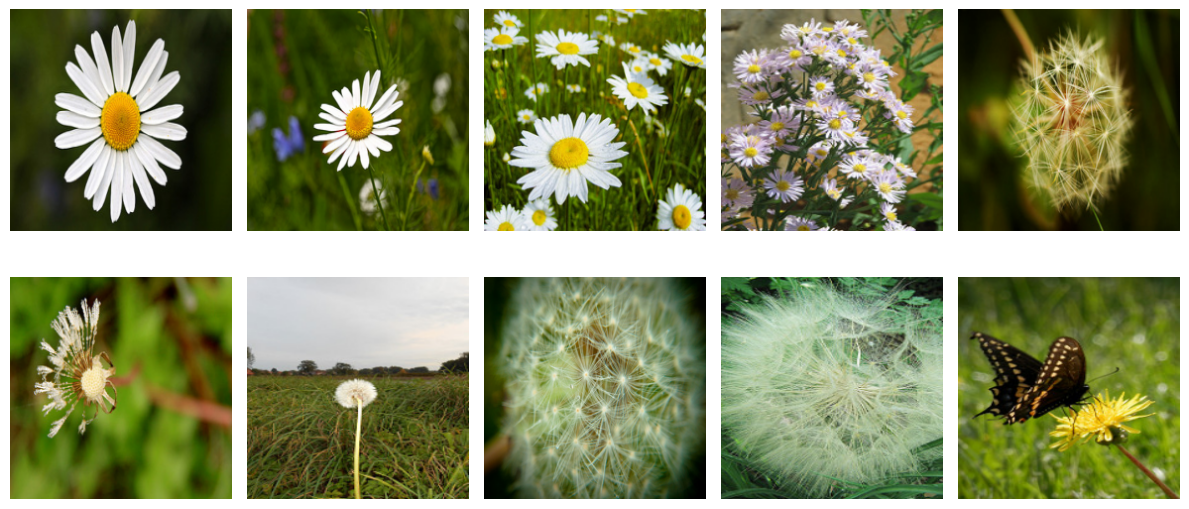

In [ ]:
visualize(dataset, idx = 760)

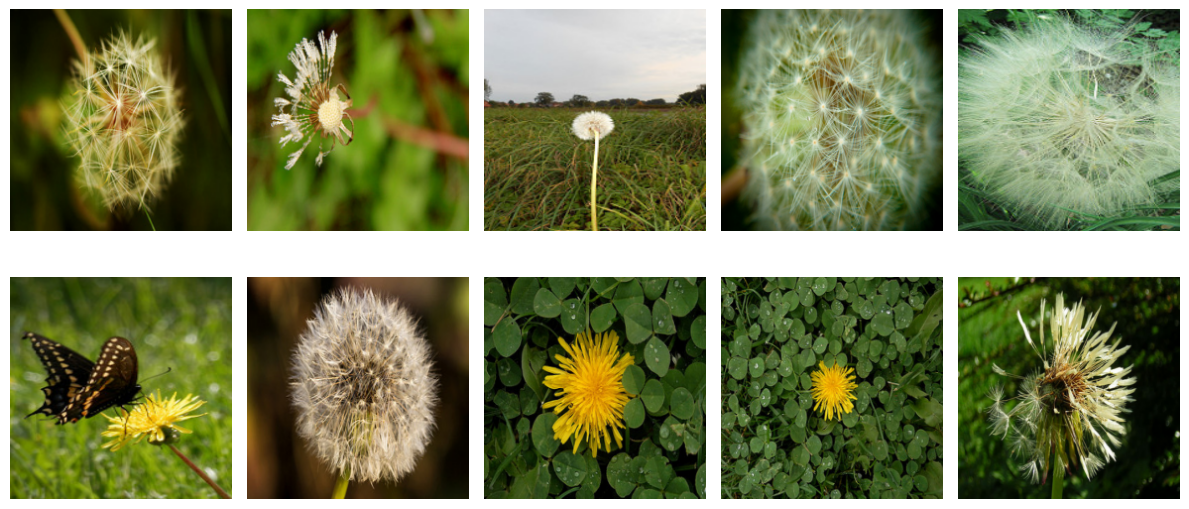

In [ ]:
visualize(dataset, idx = 764)

In [ ]:
dataset.class_to_idx

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [ ]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.25, stratify = dataset.targets)

In [ ]:
len(train_dataset), len(test_dataset)

In [ ]:
class FlowerDataset(Dataset):
  def __init__(self, dataset, transform=None, target_transform=None):# recieving a list
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

  def __get_item__(self, idx):
    return dataset[idx]

  def __len__(self):
    return




In [ ]:
train_loader = DataLoader(dataset = train_dataset,shuffle=True, batch_size=64, num_workers=2)
test_loader = DataLoader(dataset = test_dataset, shuffle = False, batch_size=64, num_workers = 2)

In [ ]:
import time

In [ ]:
st = time.time()
for i, batch in enumerate(tqdm(train_loader)):
  pass
end = time.time()
print(end-st)

100%|██████████| 51/51 [00:00<00:00, 51.47it/s]

0.9995191097259521


#train function

In [ ]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for X, y in tqdm(eval_dataloader):
            X = X.to(device)
            y = y.to(device)
            logits = model(X)
            predictions.append(logits.argmax(dim=1))
            target.append(y)

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [ ]:
def train_with_eval(model, optimizer,criterion, num_epoch, train_loader, eval_dataloader, eval_steps):
  model.to(device)
  losses = []
  acc = []
  for epoch in range(num_epoch):
    if epoch % eval_steps == 0:
              plot_loss(losses)
              model.eval()
              eval_res = evaluate(model, eval_dataloader )
              acc.append(eval_res)
              model.train()
    model.train()


    for i, batch in enumerate(tqdm(train_loader)):
        X, y = batch
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

  return losses, acc

In [ ]:
def get_loss(model, eval_dataloader, criterion) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    losses = []
    with torch.no_grad():
        for X, y in tqdm(eval_dataloader):
            X = X.to(device)
            y = y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            losses.append(loss.item())



    return sum(losses)/len(losses)

In [ ]:
def train_with_val_loss(model, optimizer,criterion, num_epoch, train_loader, eval_dataloader, eval_steps):
  model.to(device)
  losses = []
  val_losses = []
  acc = []
  for epoch in range(num_epoch):
    if epoch % eval_steps == 0:
              model.eval()
              val_loss = get_loss(model, eval_dataloader ,criterion)
              val_losses.append(val_loss)
              model.train()
    model.train()

    epoch_loss = []
    for i, batch in enumerate(tqdm(train_loader)):
        X, y = batch
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    losses.append(sum(epoch_loss)/len(epoch_loss))

  return losses, acc, val_losses

In [ ]:
def train(model, optimizer,criterion, num_epoch, train_loader):
  model.to(device)
  losses = []
  acc = []
  for epoch in range(num_epoch):
    model.train()
    if epoch == num_epoch//2:
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': losses
            }, "/content/drive/MyDrive/ML3/Flowers/models/Net_2_50_epochs_checkpoint")

    for i, batch in enumerate(tqdm(train_loader)):
        X, y = batch
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
  return losses

# eval funct

In [ ]:
def evaluate_classes(model, eval_dataloader, classes_list = [x for x in range(5)]) -> float:
    """
    Calculate accuracy on validation dataloader.
    """
    classes = {i:x for i,x in enumerate(classes_list)}
    class_correct = [0] * 5
    class_total = [0] * 5
    predictions = []
    target = []
    mistakes = torch.zeros(1,3,224,224).to(device)
    with torch.no_grad():
        for batch in eval_dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            logits = model(X)
            predictions.append(logits.argmax(dim=1))
            target.append(y)
            logs = torch.tensor(logits.argmax(dim=1))
            mistakes = torch.cat((mistakes, X[logs!=y]))

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    for x in target[target==predictions].int():
        class_correct[x]+=1
    for x in target.int():
        class_total[x]+=1
    accuracy = [class_correct[x]/class_total[x] for x in range(5)]

    return accuracy, mistakes

# plot loss

In [ ]:
def plot_loss(losses):
  plt.figure(figsize=(10, 7))
  plt.xlabel("batch")
  plt.ylabel("loss")
  plt.plot(losses)
  plt.show()

# plot accuracy

In [ ]:
def plot_accuracy(accuracy):
  plt.figure(figsize=(10, 7))
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.plot(accuracy)
  plt.show()

# Neural Network

ideas:


1.   BatchNorm2d
2.   Dropout
3.   activation functions



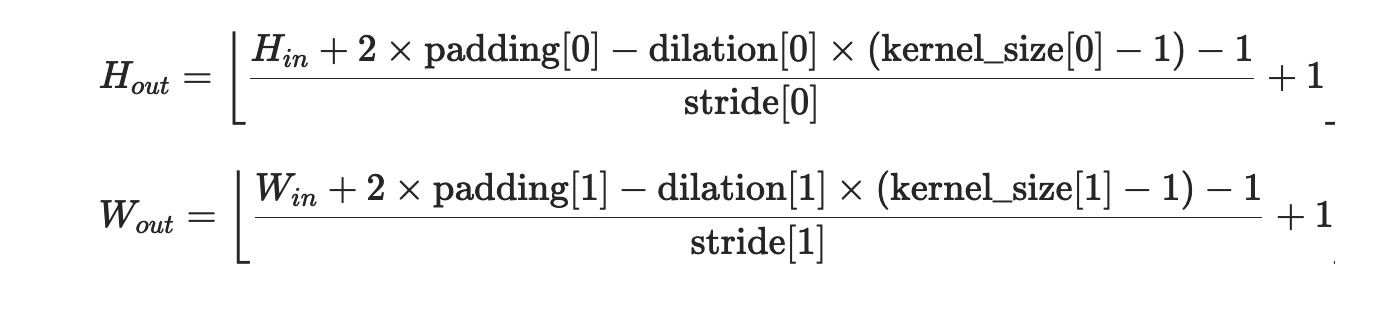

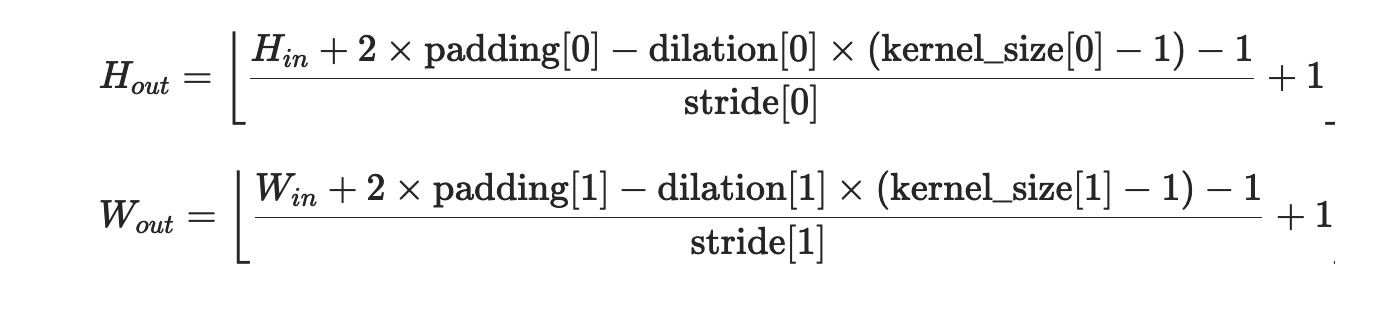

In [ ]:
class vanilla_cnn_original(nn.Module):
  def __init__(self):
    super(vanilla_cnn, self).__init__()# input is 224 by 224
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = (3,3), padding = 1, stride=1)
    self.activate = nn.ReLU()
    self.drop = nn.Dropout(p = 0.2)

    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3), padding = 1, stride=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=(3,3)) # 224 -> 222

    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (5,5), padding = 2, stride=1)
    self.maxpool3 = nn.MaxPool2d(kernel_size=(3,3))#222->220

    self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (5,5), padding = 0, stride=1, dilation = 2)#220 - 2*(5-1)-1 = 212
    self.maxpool4 = nn.MaxPool2d(kernel_size=(5,5),stride=2)  # 212 -> 207/2 = 103 + 1 = 104

    self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), padding = 0, stride=2, dilation = 2) # (104 + 2*0 - 2*(3-1)-1 )/ 2 + 1 = 51
    self.maxpool5 = nn.MaxPool2d(kernel_size=(5,5),dilation = 2)  # (51 + 0 - 2*(5-1)-1) +1 = 42

    self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 512, kernel_size = 1,padding=0)

    self.conv7 = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = (3,3), padding = 0)#42 +  0 - 3 + 1 = 40
    self.maxpool7 = nn.MaxPool2d(kernel_size=(7,7))  # 40 -> 33+1 = 34
    self.avg = nn.AvgPool2d(34)

    self.lin1 = nn.Linear(1024, 1024)
    self.lin2 = nn.Linear(1024, 1024)
    self.lin3 = nn.Linear(1024, 1024)
    self.lin4 = nn.Linear(1024, 5)



  def forward(self, x):
    layers = {}
    x = layers["conv1"] = self.conv1(x)
    x = layers["conv1 + drop"] = self.drop(x)
    x = layers["conv1 + drop + activ"]  = self.activate(x)
    print("l1", x.shape)
    x = layers["conv2"] = self.conv2(x)
    x = layers["conv2 + maxpool + drop"] = self.maxpool2(x)
    x = layers["conv2 + drop"] = self.drop(x)
    x = layers["conv2 + drop + activ"]  = self.activate(x)
    print("l2", x.shape)
    x = self.conv3(x)
    x = self.maxpool3(x)
    x = self.drop(x)
    x = self.activate(x)
    print("l3", x.shape)
    layers["conv3"] = x

    x =self.conv4(x)
    x  = self.maxpool4(x)
    x = self.drop(x)
    x =  self.activate(x)
    print("l4", x.shape)
    layers['conv4'] = x

    x = self.conv5(x)
    x = self.maxpool3(x)
    x = self.drop(x)
    x = self.activate(x)
    print("l5", x.shape)
    layers['conv5'] = x

    x = self.conv6(x)
    x = self.activate(x)

    x = self.conv7(x)
    x = self.maxpool7(x)
    x = self.drop(x)
    x = self.activate(x)
    print("l7", x.shape)

    layers['conv7'] = x
    print(x.shape)
    x = self.avg(x).squeeze()
    print(x.shape)
    x = self.activate(self.lin1(x))
    x = self.activate(self.lin2(x))
    x = self.activate(self.lin3(x))
    x = self.activate(self.lin4(x))
    return x, layers














In [ ]:
class vanilla_cnn(nn.Module):
  def __init__(self):
    super(vanilla_cnn, self).__init__()# input is 224 by 224
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = (3,3), padding = 1, stride=1)
    self.activate = nn.ReLU()
    self.drop = nn.Dropout(p = 0.2)

    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 64, kernel_size = (3,3), padding = 1, stride=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=(3,3)) # 224 -> 222

    self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 256, kernel_size = (5,5), padding = 2, stride=1)
    self.maxpool3 = nn.MaxPool2d(kernel_size=(3,3))#222->220

    self.conv4 = nn.Conv2d(in_channels = 256, out_channels = 1024, kernel_size = (5,5), padding = 0, stride=1, dilation = 2)#220 - 2*(5-1)-1 = 212
    self.maxpool4 = nn.MaxPool2d(kernel_size=(5,5),stride=2)  # 212 -> 207/2 = 103 + 1 = 104


    self.avg = nn.AvgPool2d(6)

    self.lin1 = nn.Linear(1024, 1024)
    self.lin2 = nn.Linear(1024, 1024)
    self.lin3 = nn.Linear(1024, 1024)
    self.lin4 = nn.Linear(1024, 5)



  def forward(self, x):

    x = self.drop(self.maxpool3(self.conv3(self.activate(self.drop(self.maxpool2(self.conv2(self.activate( self.drop(self.conv1(x))))))))))
    #print("l3", x.shape)



    x =  self.activate(self.drop(self.maxpool4(self.conv4(self.activate(x)))))
    #print("l4", x.shape)


    x = self.avg(x).squeeze()
    #print(x.shape)
    x = self.activate(self.lin1(x))
    x = self.activate(self.lin2(x))
    x = self.activate(self.lin3(x))
    x = self.activate(self.lin4(x))
    return x














In [ ]:
net = vanilla_cnn()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

224->74->24->6->1

In [ ]:
losses = train(net, optimizer, criterion, 5, train_loader)

 75%|███████▍  | 38/51 [24:04<08:06, 37.46s/it]

In [ ]:
path = ""

In [ ]:
torch.save(net.state_dict(), path)

## CNN try 2

In [ ]:
class Net_2(nn.Module):
  def __init__(self, regularization = "BATCHNORM", activation = nn.ReLU(), prob = 0.2):
    super(Net_2, self).__init__()
    regularization = regularization.upper()
    if  regularization == "BATCHNORM":
      self.conv_layer = nn.Sequential(
          #layer 1
          nn.Conv2d(kernel_size=5, padding = 2, in_channels = 3, out_channels = 64, stride = 1, dilation = 1),
          activation,
          # layer 2
          nn.Conv2d(kernel_size=5, padding = 2, in_channels = 64, out_channels = 128, stride = 1, dilation = 1),
          activation,
          nn.BatchNorm2d(128),
          nn.MaxPool2d(kernel_size=2),
          # layer 3
          nn.Conv2d(kernel_size = 5,  padding=2, in_channels = 128, out_channels=256, stride=1, dilation=1),
          activation,
          nn.BatchNorm2d(256),
          nn.MaxPool2d(kernel_size=2),
          # layer 4
          nn.Conv2d(kernel_size = 5,  padding=2, in_channels = 256, out_channels=512, stride=1, dilation=1),
          activation,
          nn.BatchNorm2d(512),
          nn.MaxPool2d(kernel_size=2),
          # layer 5
          nn.Conv2d(kernel_size = 5,  padding=2, in_channels = 512, out_channels=1024, stride=1, dilation=1),
          activation,
          nn.BatchNorm2d(1024),
          nn.MaxPool2d(kernel_size=2),

          # avgpool
          nn.AvgPool2d(kernel_size=14)

# out = 1024 pixels



          )
      pass
    elif regularization == "DROPOUT":
      self.conv_layer = nn.Sequential(
          #layer 1
          nn.Conv2d(kernel_size=5, padding = 2, in_channels = 3, out_channels = 64, stride = 1, dilation = 1),
          activation,
          # layer 2
          nn.Conv2d(kernel_size=5, padding = 2, in_channels = 64, out_channels = 128, stride = 1, dilation = 1),
          activation,
          nn.Dropout(p=prob),
          nn.MaxPool2d(kernel_size=2),
          # layer 3
          nn.Conv2d(kernel_size = 5,  padding=2, in_channels = 128, out_channels=256, stride=1, dilation=1),
          activation,
          nn.Dropout(p=prob),
          nn.MaxPool2d(kernel_size=2),
          # layer 4
          nn.Conv2d(kernel_size = 5,  padding=2, in_channels = 256, out_channels=512, stride=1, dilation=1),
          activation,
          nn.Dropout(p=prob),
          nn.MaxPool2d(kernel_size=2),
          # layer 5
          nn.Conv2d(kernel_size = 5,  padding=2, in_channels = 512, out_channels=1024, stride=1, dilation=1),
          activation,
          nn.Dropout(p=prob),
          nn.MaxPool2d(kernel_size=2),

          # avgpool
          nn.AvgPool2d(kernel_size=14)

# out = 1024 pixels



          )
      pass
    else:
      raise ValueError("Unaccaptable regularization!")

    self.lin_layers = nn.Sequential(nn.Linear(1024, 1024),
                                    activation,
                                    nn.Linear(1024, 1024),
                                    activation,
                                    nn.Linear(1024, 1024),
                                    activation,
                                    nn.Linear(1024, 5))


  def forward(self, x):
    x = self.conv_layer(x)
    #print(x.shape)
    x = x.squeeze()
    #print(x.shape)
    x = self.lin_layers(x)
    return x

### Adam + CrossEntropyLoss + 5 (epochs)

In [ ]:
model = Net_2()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
num_epoch = 5

In [ ]:
full_loader = DataLoader(dataset = dataset, shuffle=True, batch_size=16, num_workers=2)

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
train_loader = DataLoader(dataset = train_dataset, shuffle=True, batch_size=16, num_workers=2)
test_loader = DataLoader(dataset = test_dataset, shuffle=False, batch_size=16, num_workers=2)

In [ ]:
dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
losses = train(model, optimizer, criterion, num_epoch, train_loader)

100%|██████████| 216/216 [01:27<00:00,  2.47it/s]


### Loss graph

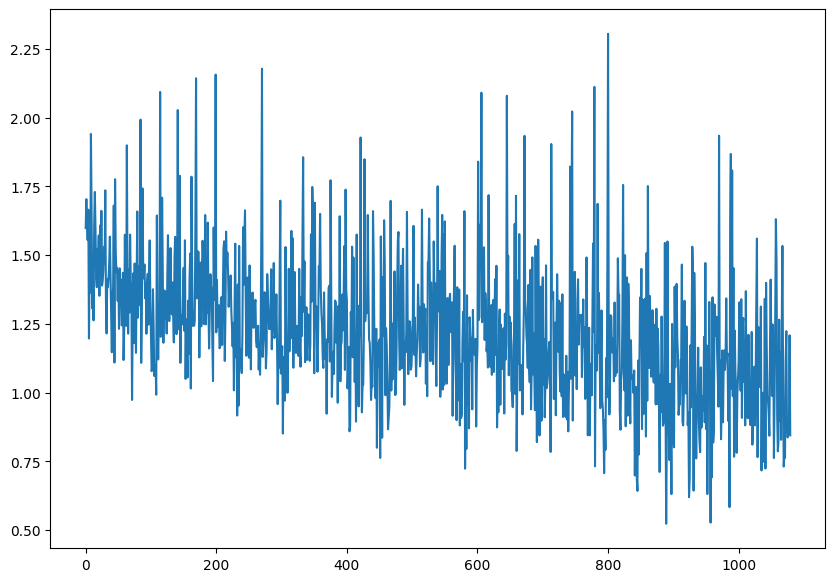

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.show()

noisy, but slowly decreasing. Let's evaluate on train, and increase the batch size + epochs num

In [ ]:
acc, mistakes = evaluate_classes(model, test_loader)

<ipython-input-32-a82973b3347d>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logs = torch.tensor(logits.argmax(dim=1))


In [ ]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
for x in acc:
  print(x)

0.6047904191616766
0.8189655172413793
0.4166666666666667
0.5546875
0.6269430051813472


In [ ]:
mistakes.shape

torch.Size([322, 3, 224, 224])

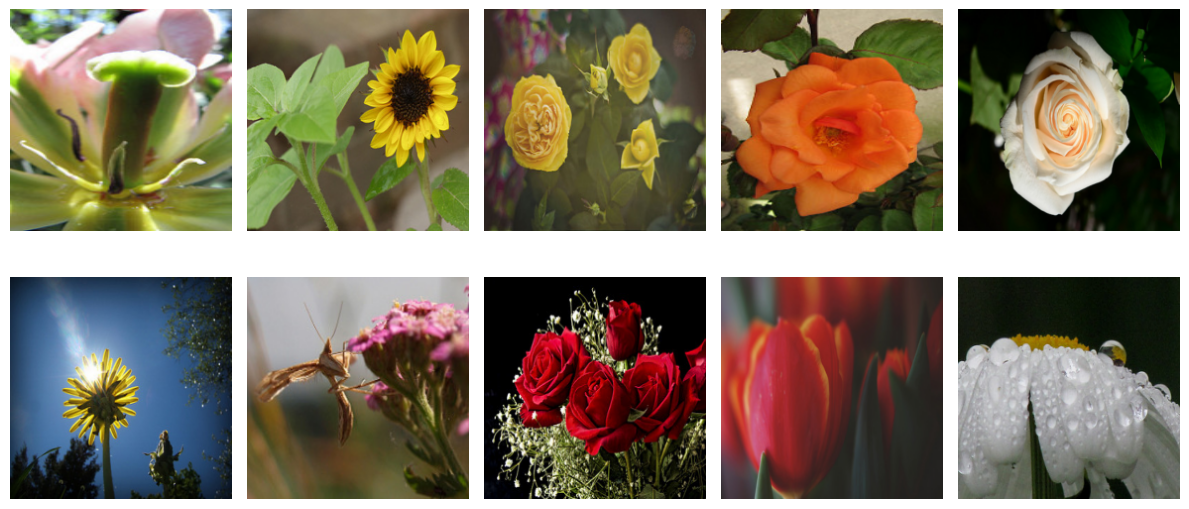

In [ ]:
visualize(mistakes)

In [ ]:
RESUlTS = {"Net_2" : acc}

## try 3 Stratify split

In [ ]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify = dataset.targets)
train_batch = 16
test_batch = 16

train_loader = DataLoader(train_dataset, batch_size = train_batch, shuffle = True, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = test_batch, shuffle = False, num_workers=2)

In [ ]:
model = Net_2()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
num_epoch = 5

In [ ]:
losses = train(model, optimizer, criterion, num_epoch, train_loader)

100%|██████████| 203/203 [01:21<00:00,  2.48it/s]


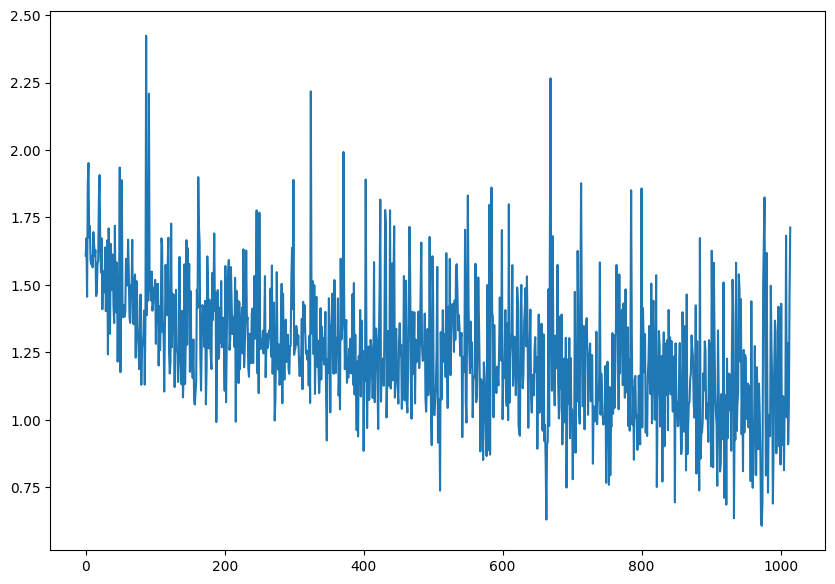

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.show()

In [ ]:
acc, mistakes = evaluate_classes(model, test_loader)

<ipython-input-32-a82973b3347d>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logs = torch.tensor(logits.argmax(dim=1))


In [ ]:
" ".join([str(x) for x in acc])

'0.418848167539267 0.6577946768060836 0.4336734693877551 0.8315217391304348 0.6138211382113821'

## try 4: batch_size = 32

In [ ]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify = dataset.targets)
train_batch = 32
test_batch = 32

train_loader = DataLoader(train_dataset, batch_size = train_batch, shuffle = True, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = test_batch, shuffle = False, num_workers=2)

In [ ]:
model = Net_2()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
num_epoch = 5

In [ ]:
losses = train(model, optimizer, criterion, num_epoch, train_loader)

100%|██████████| 108/108 [01:23<00:00,  1.29it/s]


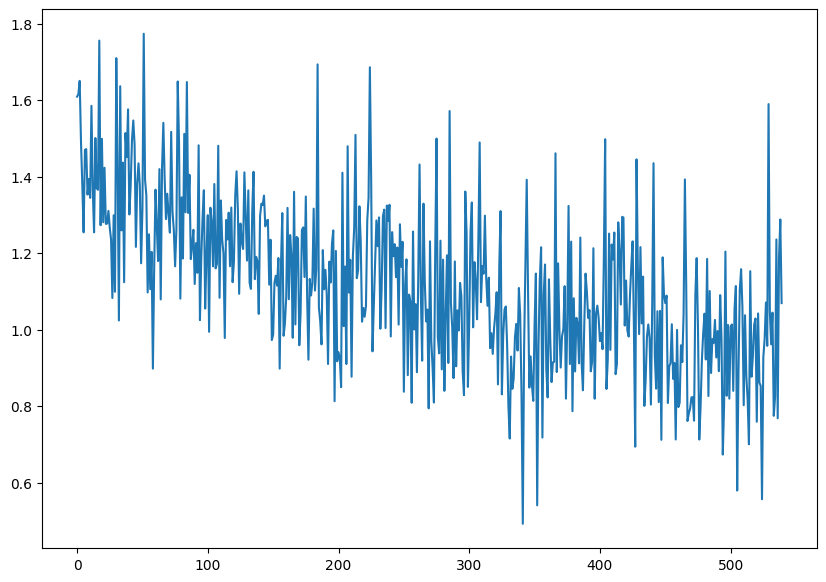

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.show()

In [ ]:
acc, mistakes = evaluate_classes(model, test_loader)

<ipython-input-32-a82973b3347d>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logs = torch.tensor(logits.argmax(dim=1))


In [ ]:
" ".join([str(x) for x in acc])

'0.5555555555555556 0.8 0.12738853503184713 0.6598639455782312 0.817258883248731'

In [ ]:
sum(acc)/len(acc)

0.592013383882873

Observation: bigger batch -> more successful classification of dundalions, sunflowers and tulips

## try 5: increase the number of workers

In [ ]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify = dataset.targets)
train_batch = 32
test_batch = 32

train_loader = DataLoader(train_dataset, batch_size = train_batch, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size = test_batch, shuffle = False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
model = Net_2()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
num_epoch = 5

In [ ]:
losses = train(model, optimizer, criterion, num_epoch, train_loader)

100%|██████████| 108/108 [01:23<00:00,  1.29it/s]


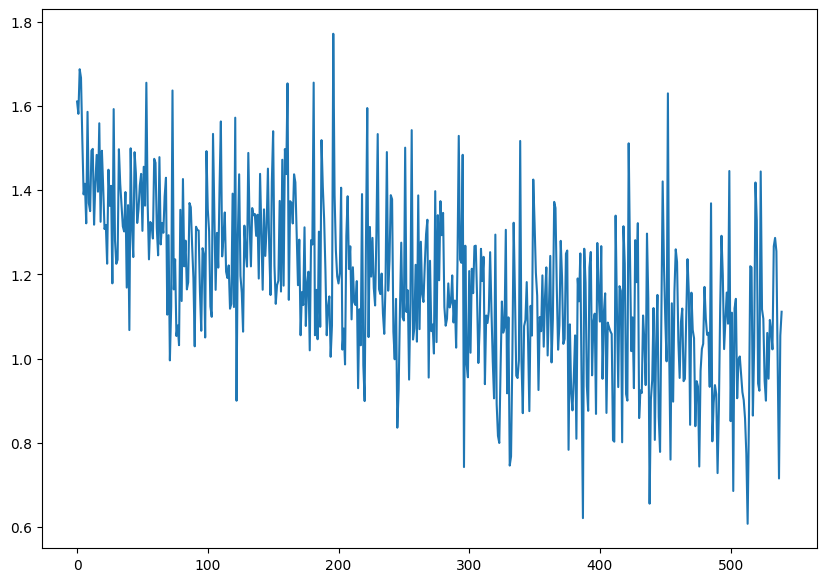

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.show()

In [ ]:
acc, mistakes = evaluate_classes(model, test_loader)

<ipython-input-32-a82973b3347d>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logs = torch.tensor(logits.argmax(dim=1))


In [ ]:
" ".join([str(x) for x in acc])

'0.5882352941176471 0.6666666666666666 0.25477707006369427 0.7482993197278912 0.7360406091370558'

In [ ]:
sum(acc)/len(acc)

0.598803791942591

## try 6: increase the number of epochs

In [ ]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify = dataset.targets)
train_batch = 32
test_batch = 32

train_loader = DataLoader(train_dataset, batch_size = train_batch, shuffle = True, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = test_batch, shuffle = False, num_workers=2)

In [ ]:
model = Net_2()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
num_epoch = 10

In [ ]:
losses = train(model, optimizer, criterion, num_epoch, train_loader)

100%|██████████| 108/108 [01:23<00:00,  1.29it/s]


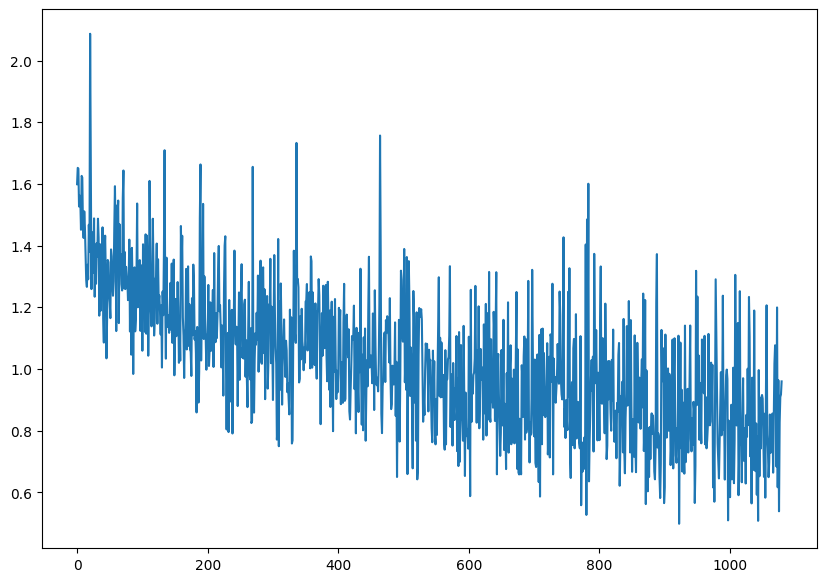

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.show()

In [ ]:
acc, mistakes = evaluate_classes(model, test_loader)

<ipython-input-32-a82973b3347d>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logs = torch.tensor(logits.argmax(dim=1))


In [ ]:
" ".join([str(x) for x in acc])

'0.7973856209150327 0.7285714285714285 0.5222929936305732 0.782312925170068 0.5989847715736041'

In [ ]:
sum(acc)/len(acc)

0.6859095479721413

## try 7: drop out instead of batchnorm

In [ ]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify = dataset.targets)
train_batch = 32
test_batch = 32

train_loader = DataLoader(train_dataset, batch_size = train_batch, shuffle = True, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = test_batch, shuffle = False, num_workers=2)

In [ ]:
model = Net_2(regularization = "DROPOUT", activation = nn.ReLU(), prob = 0.2)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
num_epoch = 10

In [ ]:
losses = train(model, optimizer, criterion, num_epoch, train_loader)

100%|██████████| 108/108 [01:15<00:00,  1.44it/s]


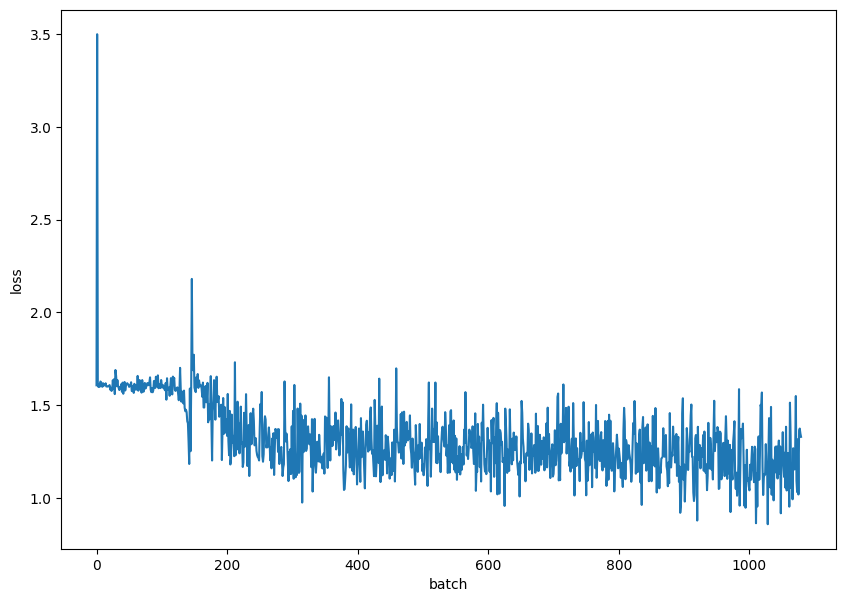

In [ ]:
plot_loss(losses)

In [ ]:
acc, mistakes = evaluate_classes(model, test_loader)

<ipython-input-32-a82973b3347d>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logs = torch.tensor(logits.argmax(dim=1))


In [ ]:
" ".join([str(x) for x in acc])

'0.0 0.9571428571428572 0.2929936305732484 0.11564625850340136 0.6040609137055838'

In [ ]:
sum(acc)/len(acc)

0.39396873198501814

## try 8 : 100 epochs

In [ ]:
model = Net_2()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
num_epoch = 100

In [ ]:
losses = train(model, optimizer, criterion, num_epoch, train_loader)

  5%|▍         | 5/108 [00:04<01:35,  1.08it/s]


KeyboardInterrupt: ignored

In [ ]:
plot_loss(losses)

In [ ]:
acc, mistakes = evaluate_classes(model, test_loader)

<ipython-input-17-a82973b3347d>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logs = torch.tensor(logits.argmax(dim=1))


In [ ]:
" ".join([str(x) for x in acc])

'0.803921568627451 0.8952380952380953 0.7515923566878981 0.8639455782312925 0.766497461928934'

## 81% accuracy after over 50 epochs !

In [ ]:
sum(acc)/len(acc)

0.8162390121427343

In [ ]:
path = "/content/drive/MyDrive/ML3/Flowers/models/Net_2_50_epochs_"
torch.save(model.state_dict(), path)

getting the last checkpoint

In [ ]:
PATH ="/content/drive/MyDrive/ML3/Flowers/models/Net_2_50_epochs_checkpoint"
model = Net_2()
optimizer = torch.optim.Adam(model.parameters())

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']



## try 9: combatting overfitting, method a - early stopping

In [ ]:
model = Net_2()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
num_epoch = 30

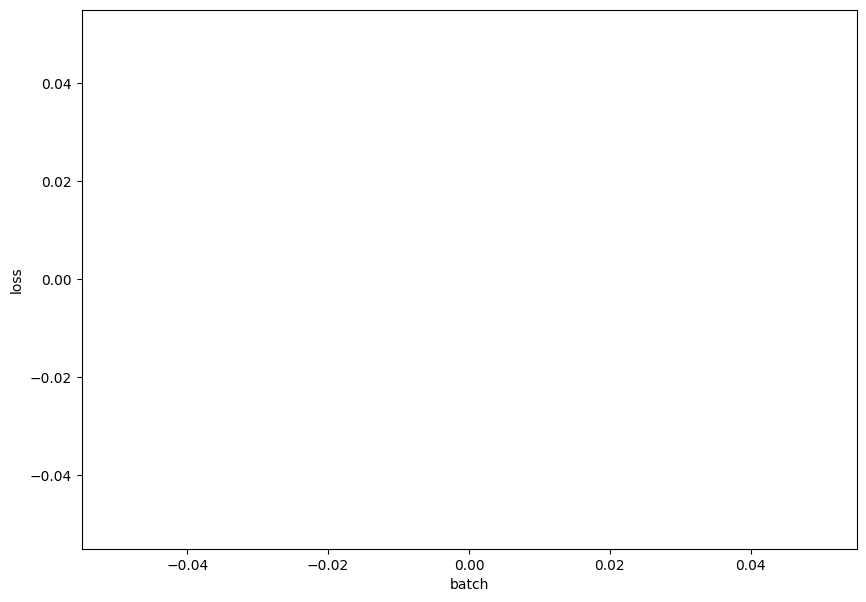

100%|██████████| 108/108 [01:21<00:00,  1.33it/s]


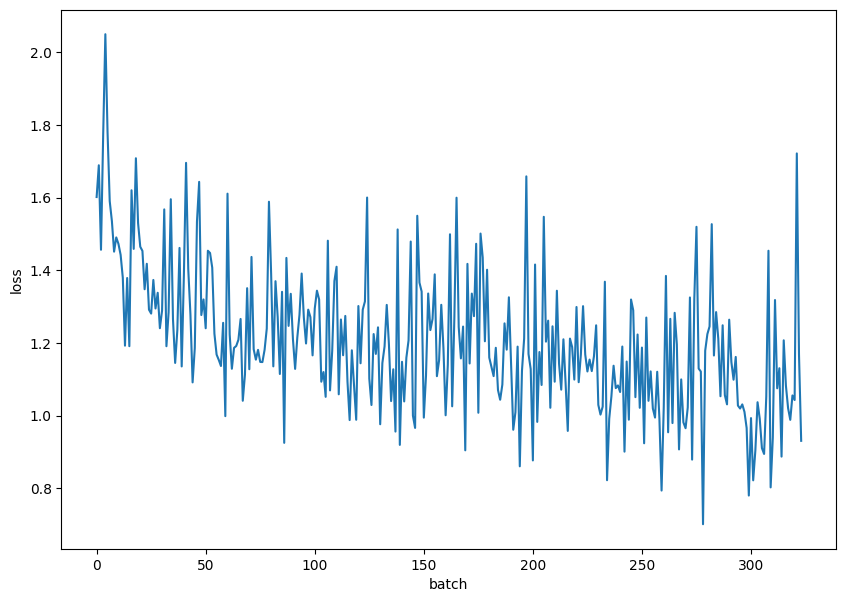

100%|██████████| 108/108 [01:20<00:00,  1.33it/s]


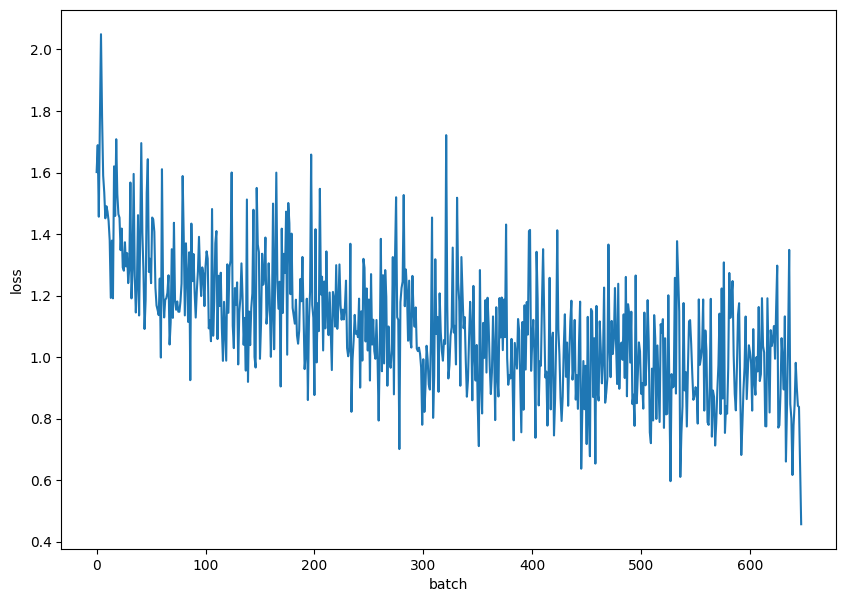

100%|██████████| 108/108 [01:21<00:00,  1.33it/s]


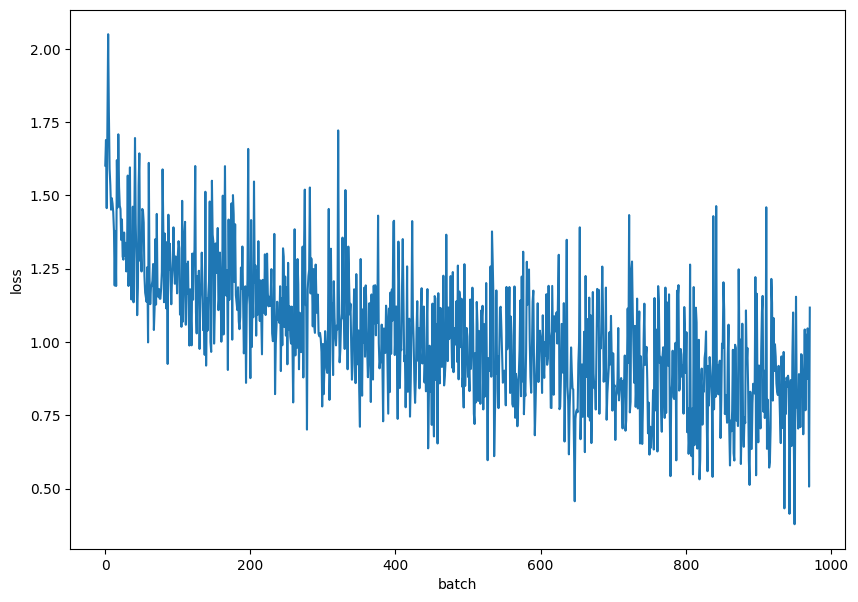

100%|██████████| 108/108 [01:21<00:00,  1.33it/s]


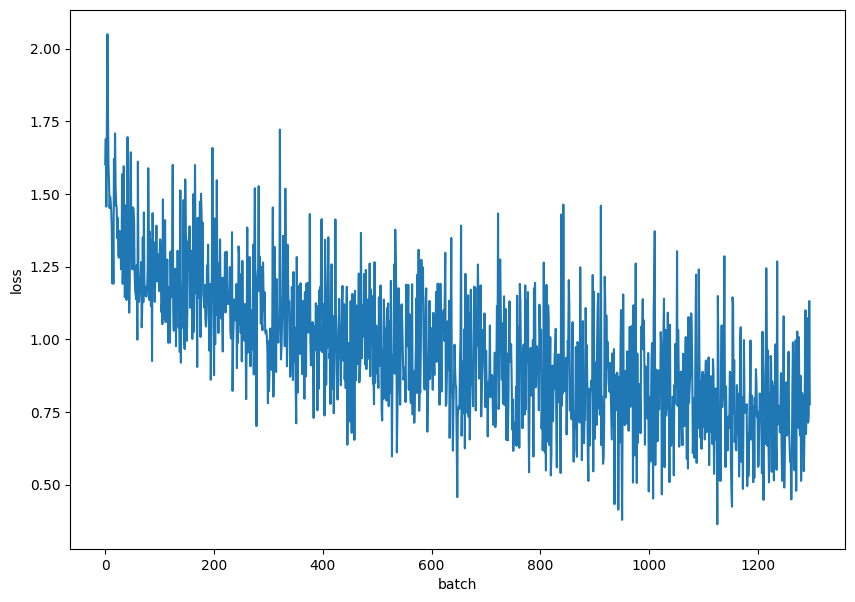

100%|██████████| 108/108 [01:21<00:00,  1.33it/s]


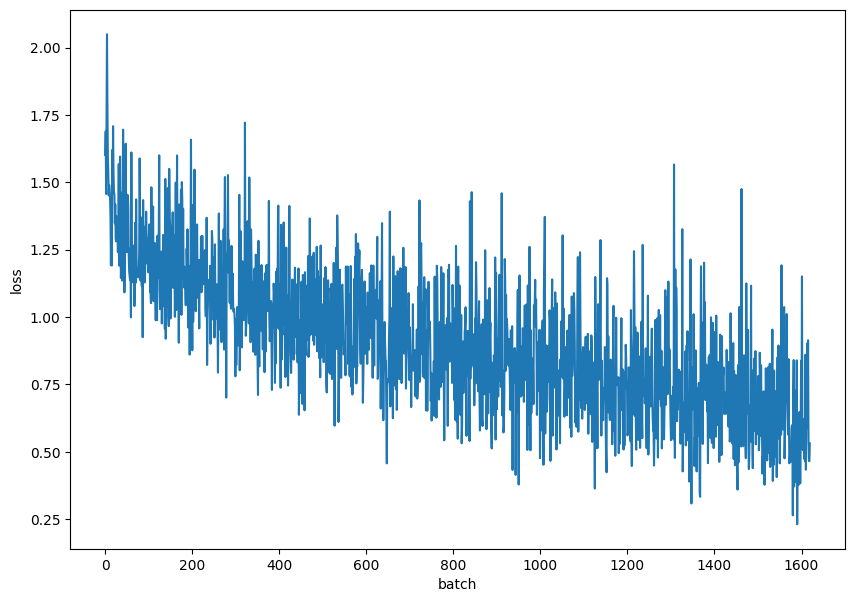

100%|██████████| 108/108 [01:20<00:00,  1.34it/s]


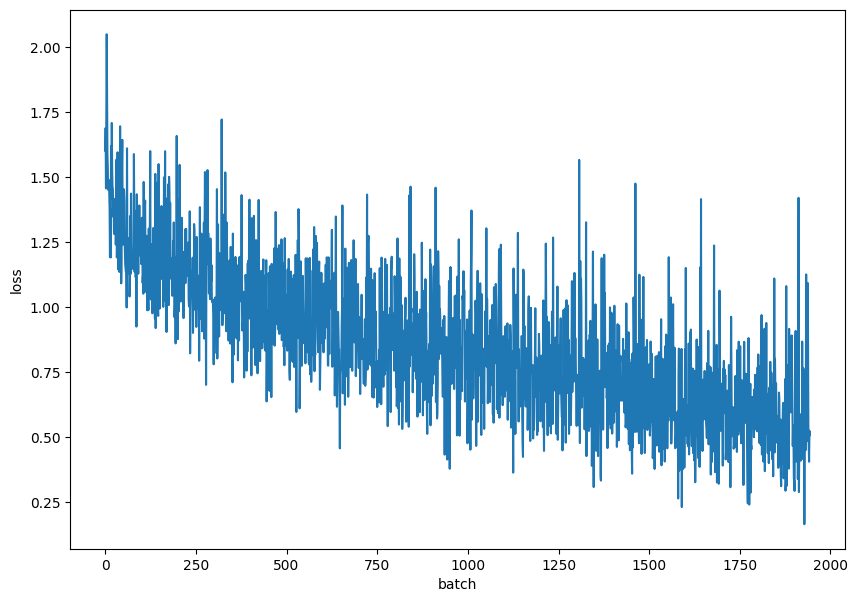

100%|██████████| 108/108 [01:20<00:00,  1.34it/s]


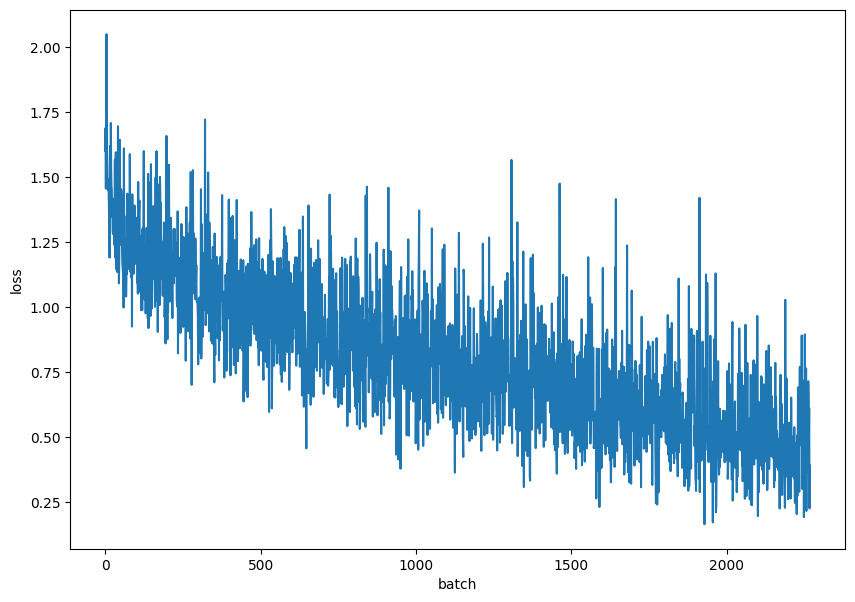

100%|██████████| 108/108 [01:20<00:00,  1.34it/s]


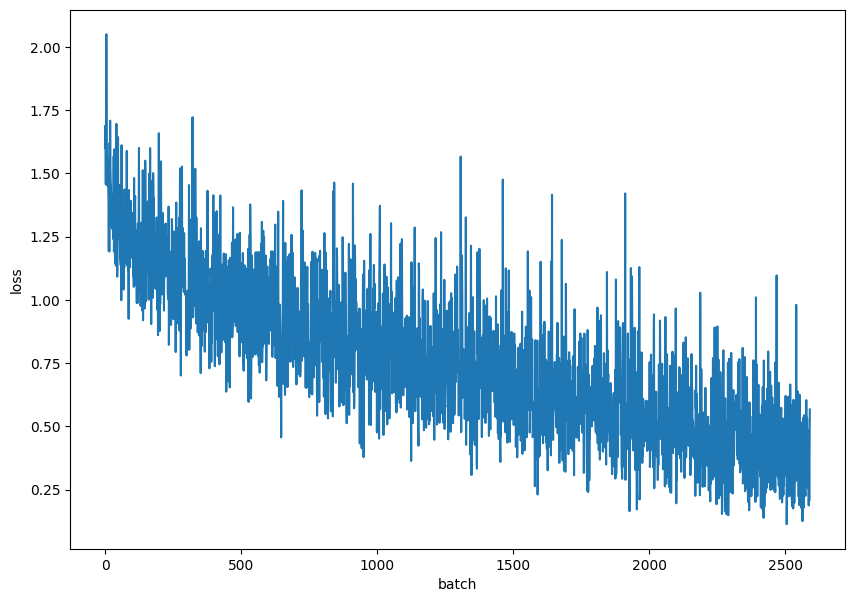

100%|██████████| 108/108 [01:21<00:00,  1.33it/s]


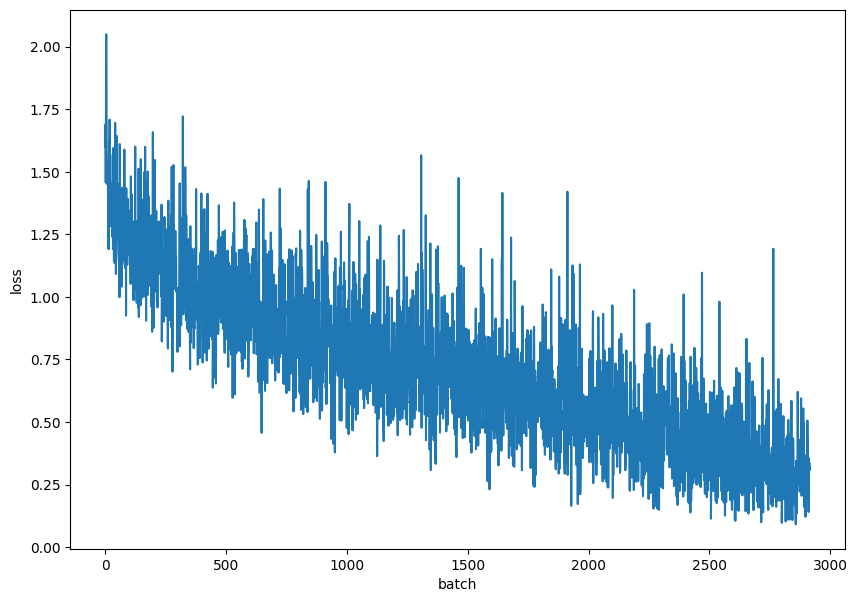

100%|██████████| 108/108 [01:20<00:00,  1.34it/s]


In [ ]:
losses, accuracy = train_with_eval(model, optimizer, criterion, num_epoch, train_loader, test_loader, 3)

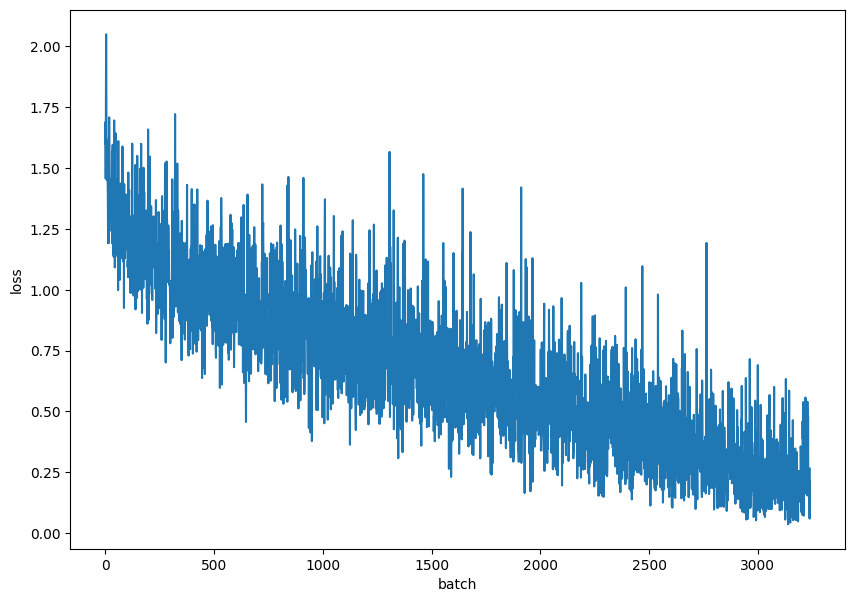

In [ ]:
plot_loss(losses)

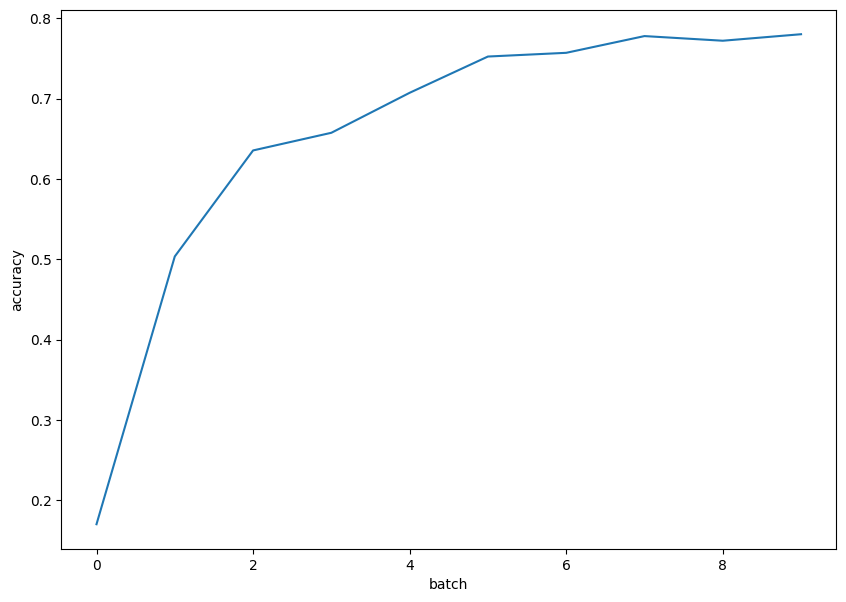

In [ ]:
plot_accuracy(accuracy)

In [ ]:
evaluate(model, test_loader)

100%|██████████| 27/27 [00:05<00:00,  4.55it/s]


0.8159722089767456

In [ ]:
evaluate(model, train_loader)

100%|██████████| 108/108 [00:23<00:00,  4.52it/s]


0.9348393082618713

In [ ]:
acc, mistakes = evaluate_classes(model, test_loader)

<ipython-input-30-a82973b3347d>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logs = torch.tensor(logits.argmax(dim=1))


In [ ]:
for x in acc:
  print(x)

0.7973856209150327
0.8142857142857143
0.8343949044585988
0.8639455782312925
0.7817258883248731


## try 10: combatting overfitting, mathod b: decreasing the learning rate

In [ ]:
model = Net_2()

optimizer = torch.optim.Adam(model.parameters(), 0.0005)
criterion = nn.CrossEntropyLoss()
num_epoch = 50

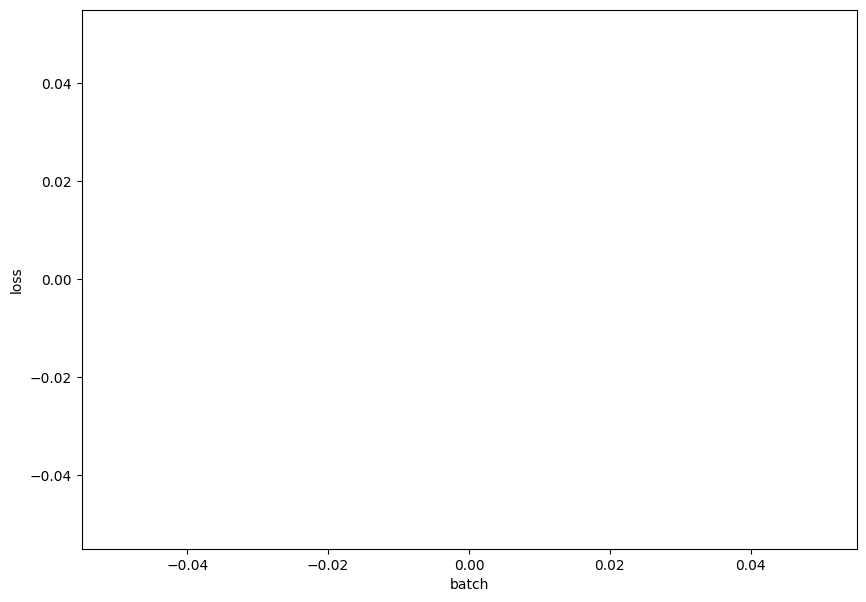

100%|██████████| 108/108 [01:21<00:00,  1.33it/s]


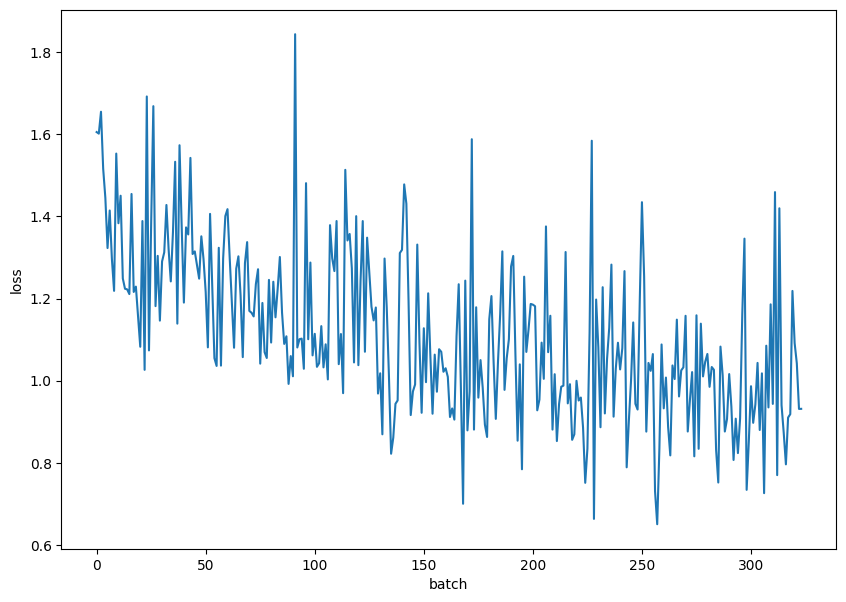

100%|██████████| 108/108 [01:20<00:00,  1.33it/s]


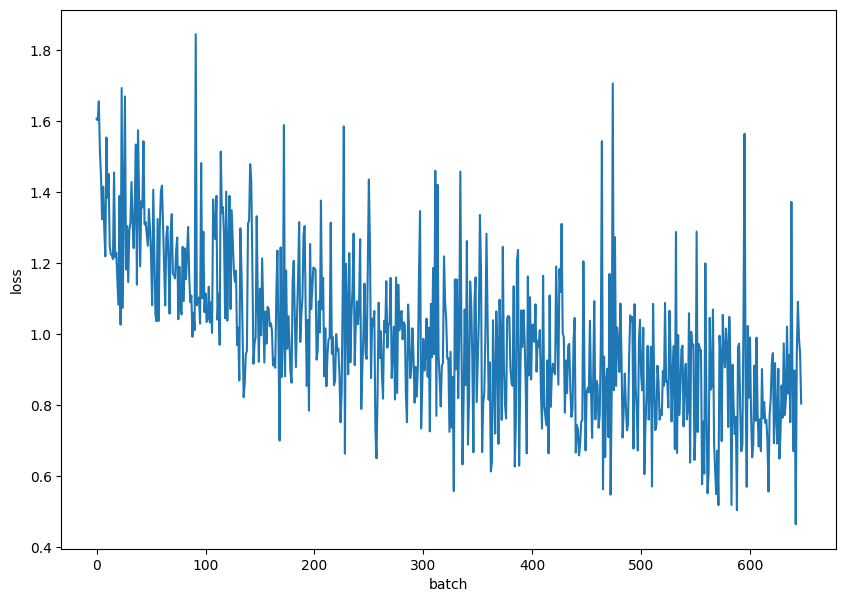

100%|██████████| 108/108 [01:21<00:00,  1.33it/s]


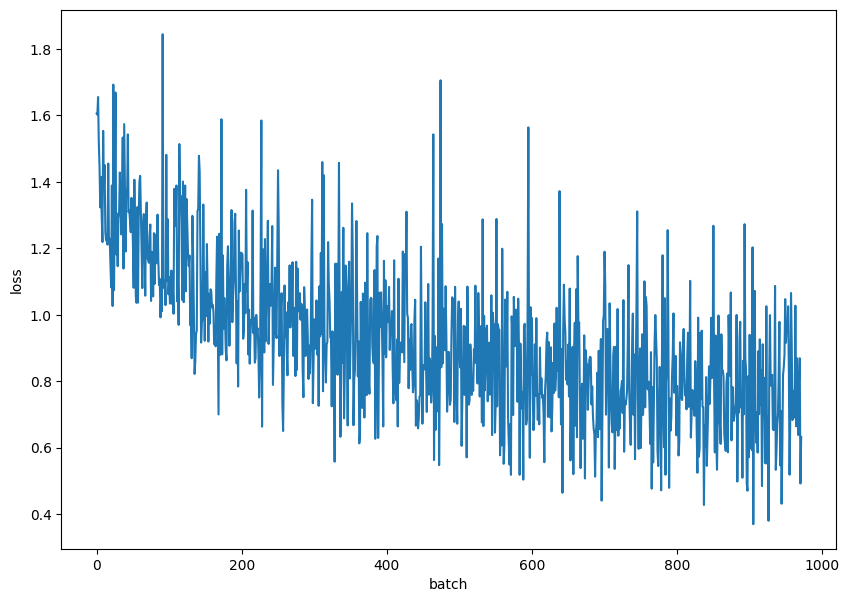

100%|██████████| 108/108 [01:20<00:00,  1.34it/s]


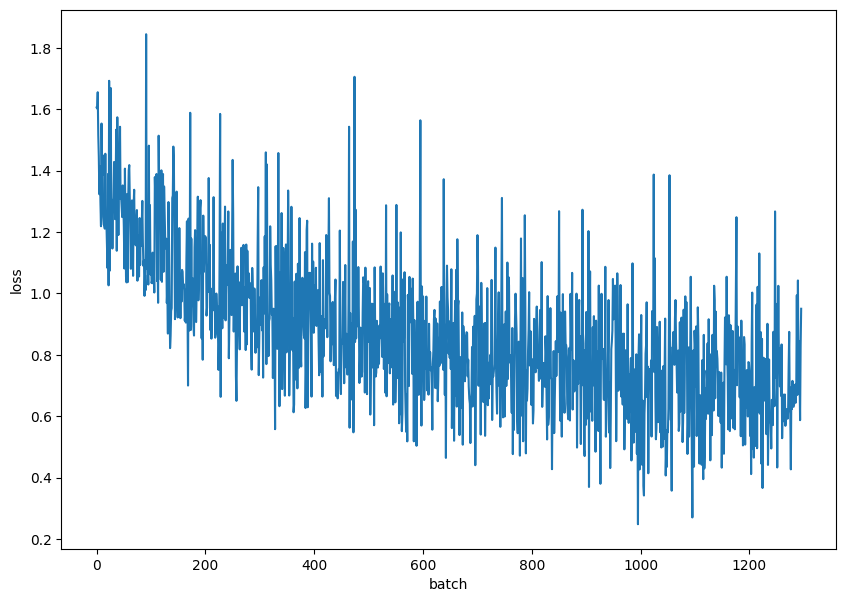

100%|██████████| 108/108 [01:20<00:00,  1.33it/s]


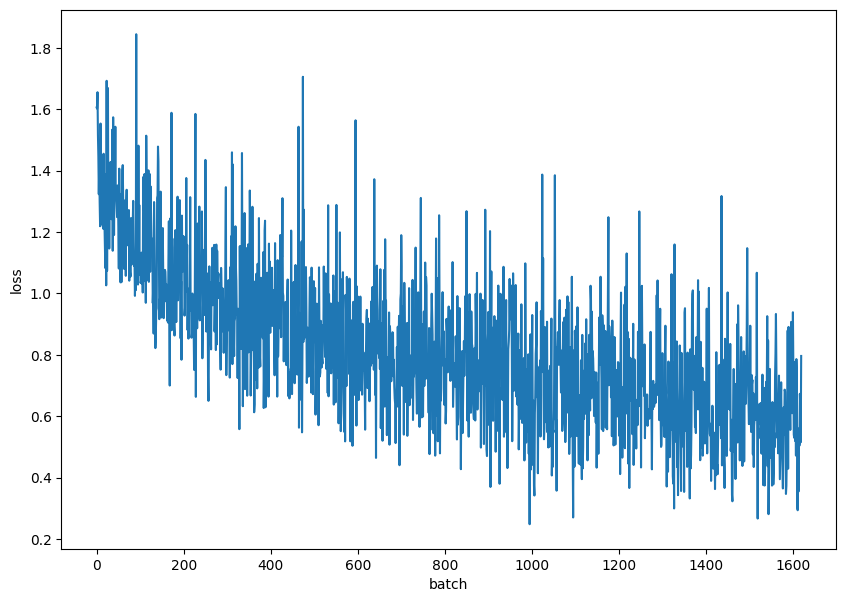

100%|██████████| 108/108 [01:20<00:00,  1.34it/s]


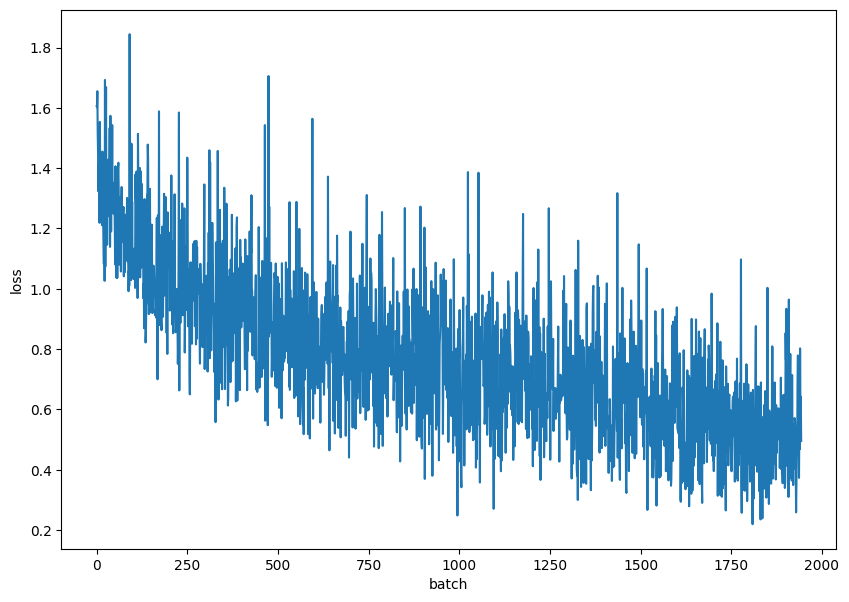

100%|██████████| 108/108 [01:20<00:00,  1.34it/s]


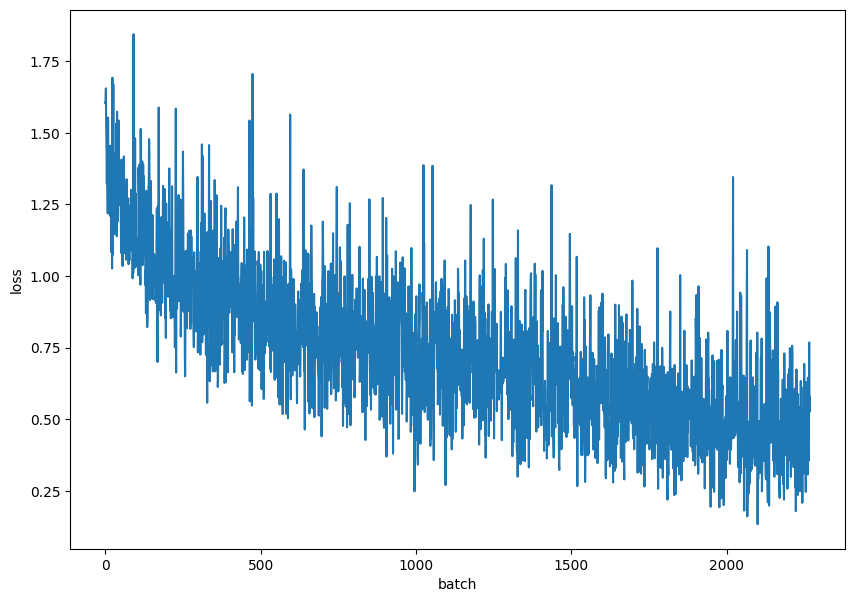

100%|██████████| 108/108 [01:20<00:00,  1.33it/s]


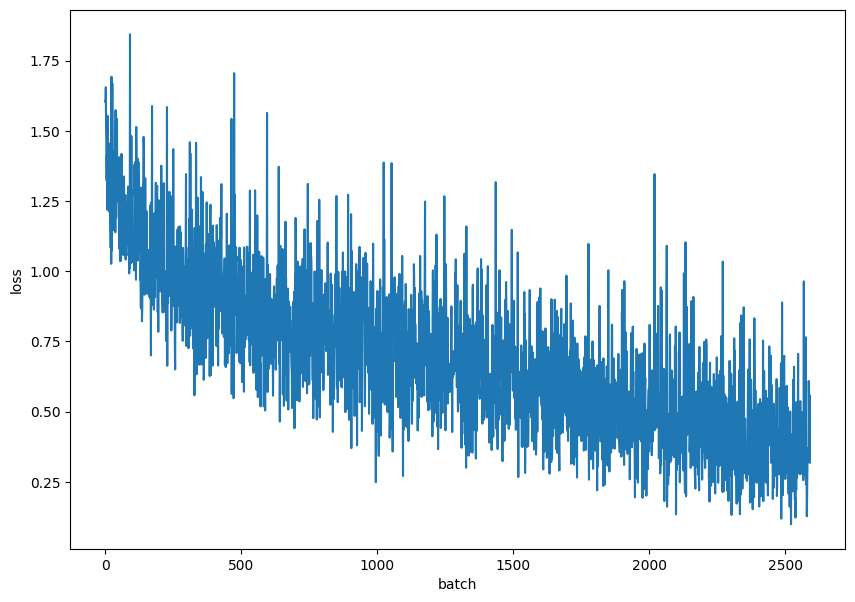

100%|██████████| 108/108 [01:20<00:00,  1.34it/s]


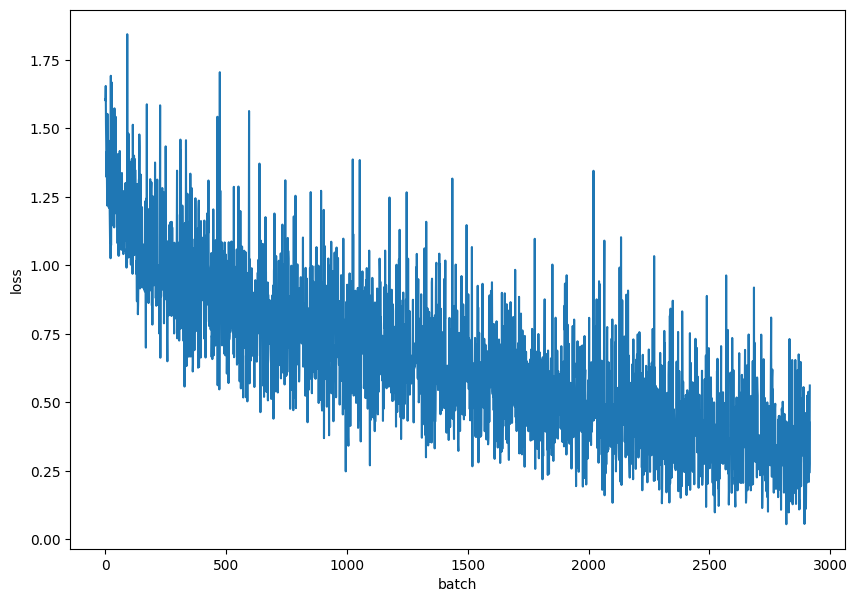

100%|██████████| 108/108 [01:20<00:00,  1.34it/s]


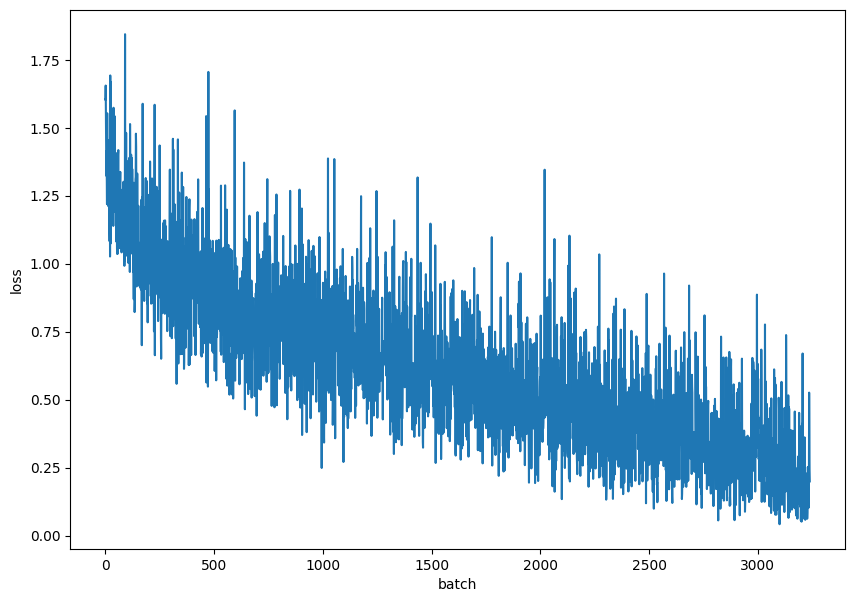

100%|██████████| 108/108 [01:20<00:00,  1.34it/s]


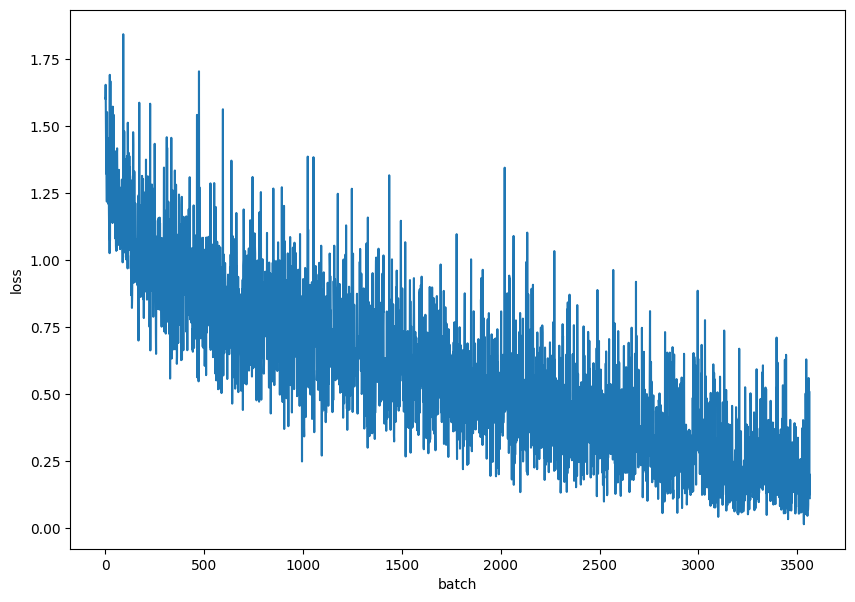

100%|██████████| 108/108 [01:20<00:00,  1.34it/s]


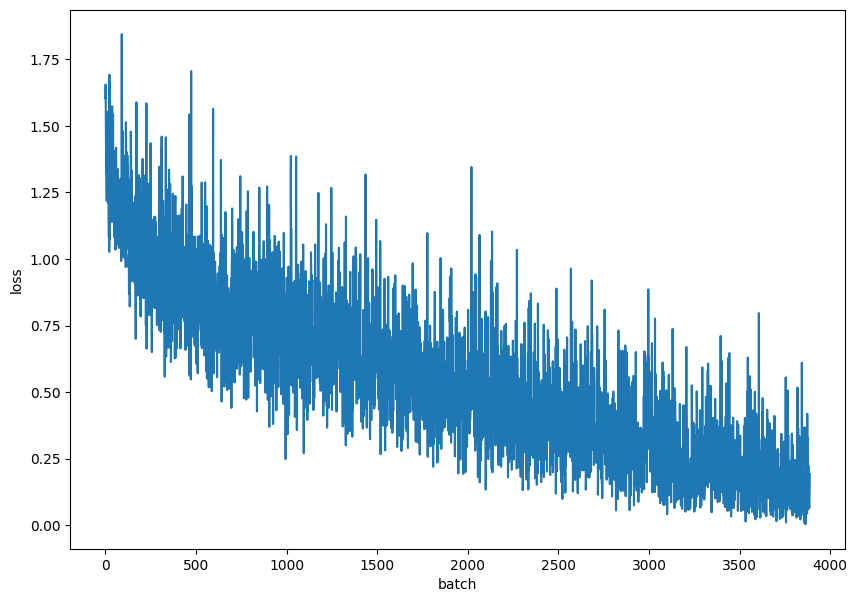

100%|██████████| 108/108 [01:20<00:00,  1.34it/s]


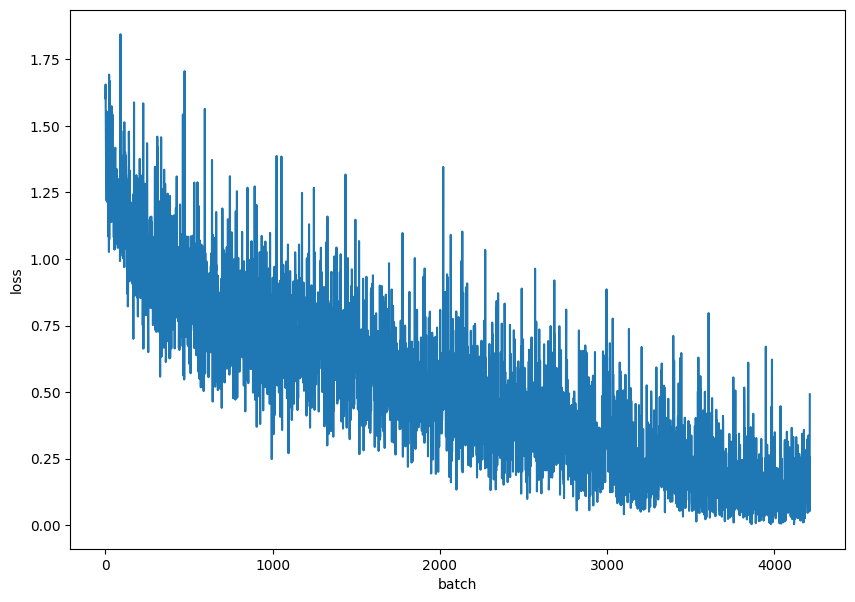

100%|██████████| 108/108 [01:20<00:00,  1.34it/s]


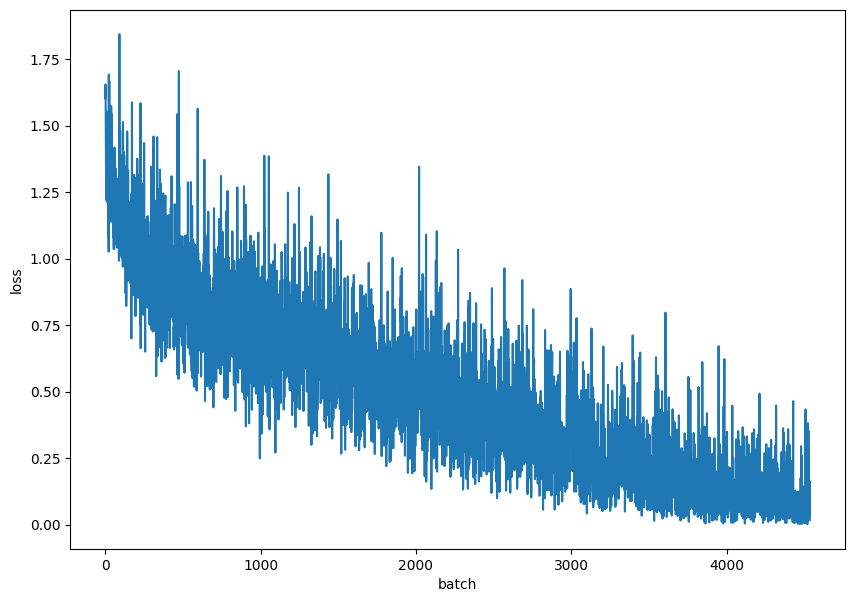

100%|██████████| 108/108 [01:20<00:00,  1.34it/s]


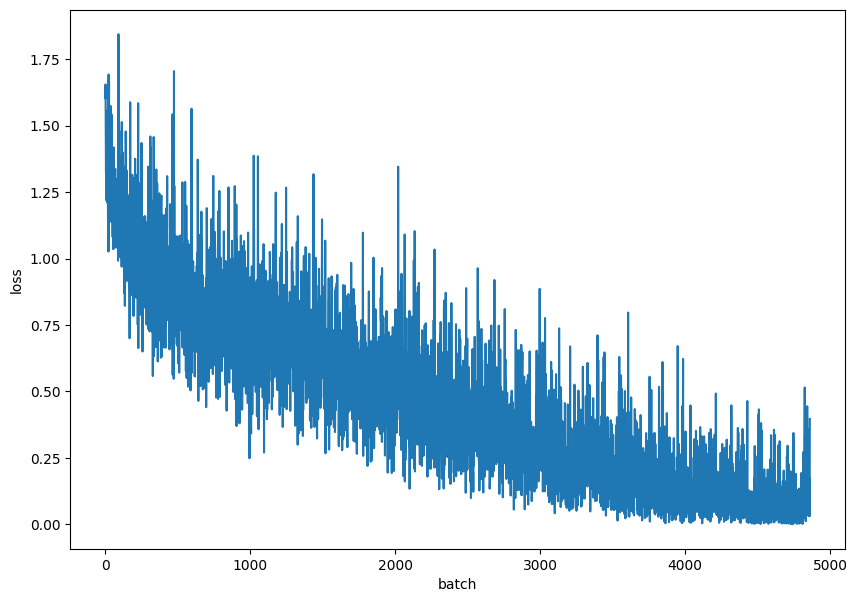

100%|██████████| 108/108 [01:20<00:00,  1.34it/s]


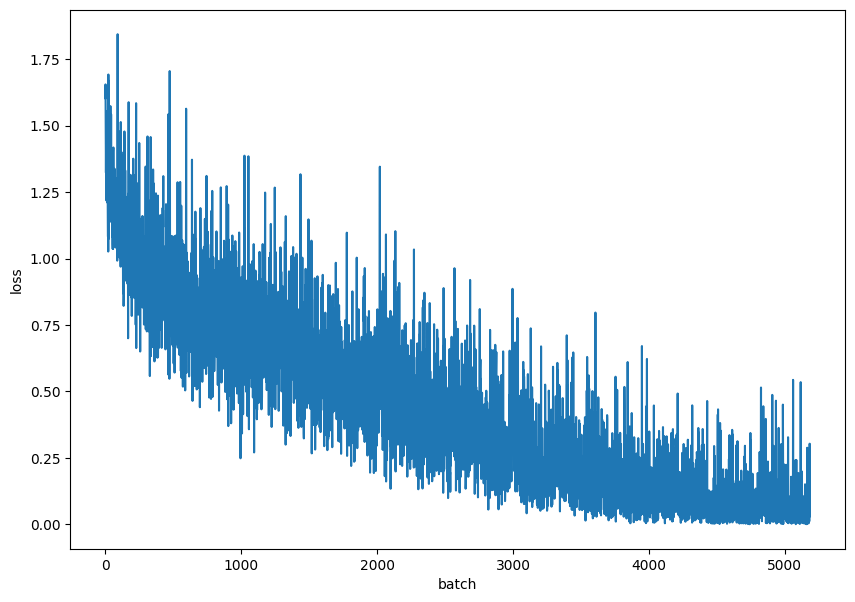

100%|██████████| 108/108 [01:20<00:00,  1.35it/s]


In [ ]:
losses, accuracy = train_with_eval(model, optimizer, criterion, num_epoch, train_loader, test_loader, 3)

In [ ]:
evaluate(model, test_loader)

100%|██████████| 27/27 [00:05<00:00,  4.61it/s]


0.819444477558136

## try 11: combatting overfitting


In [ ]:
model = Net_2()

optimizer = torch.optim.Adam(model.parameters(), 0.0005)
criterion = nn.CrossEntropyLoss()
num_epoch = 50

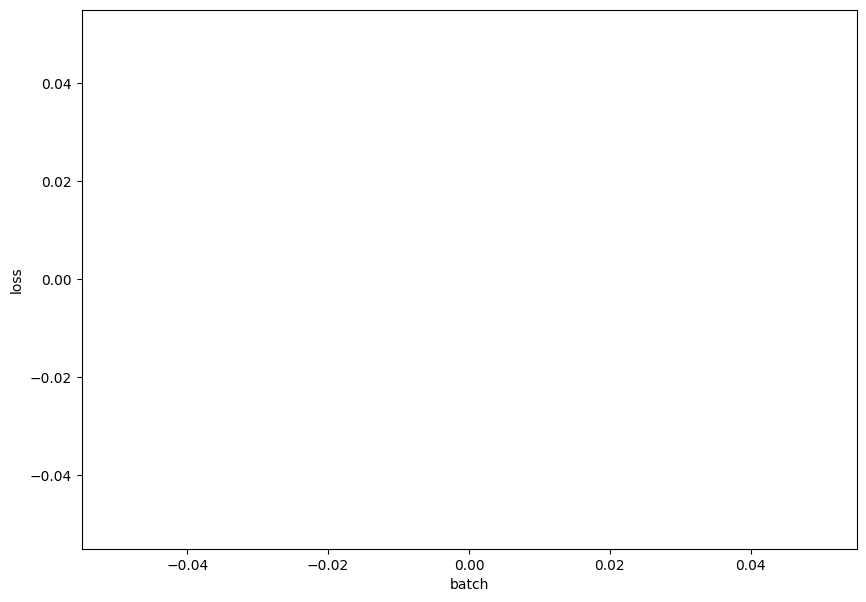

100%|██████████| 108/108 [01:26<00:00,  1.25it/s]


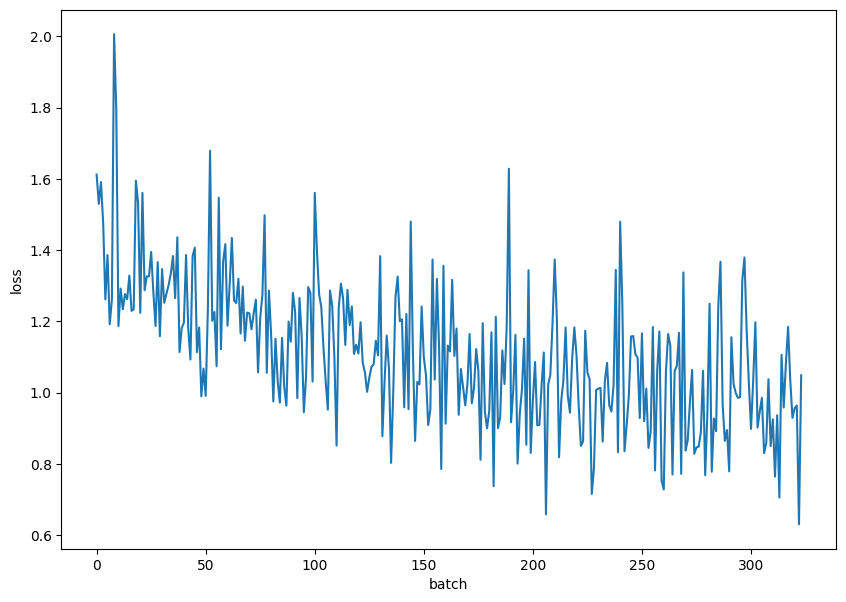

100%|██████████| 108/108 [01:26<00:00,  1.25it/s]


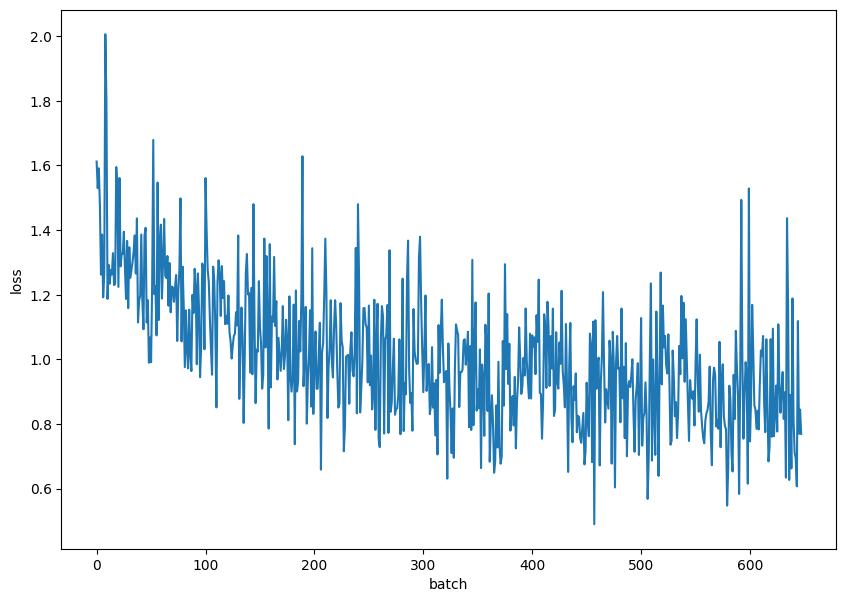

100%|██████████| 108/108 [01:26<00:00,  1.25it/s]


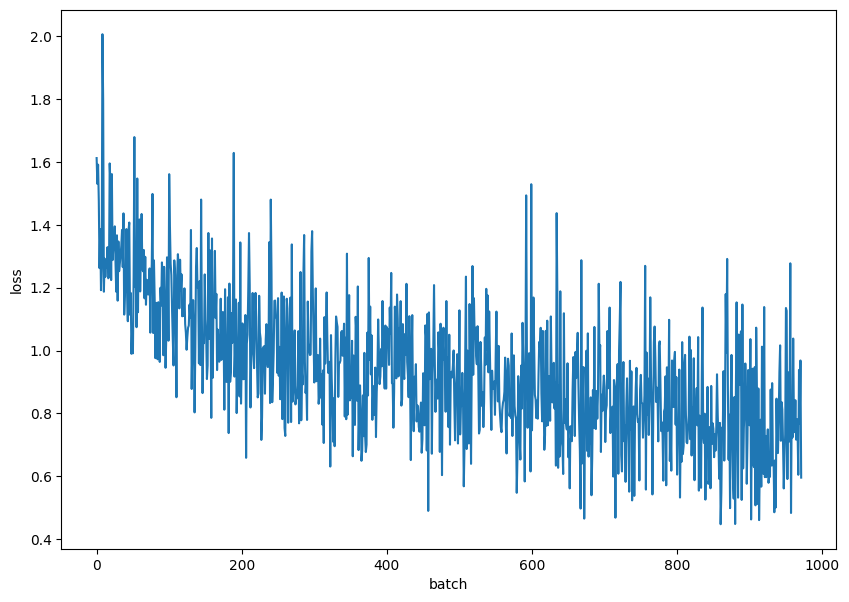

100%|██████████| 108/108 [01:26<00:00,  1.25it/s]


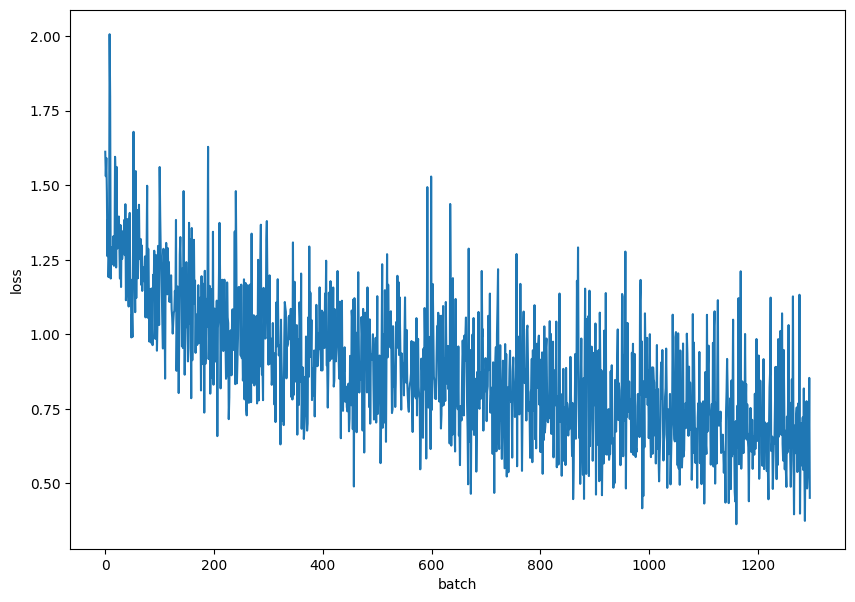

100%|██████████| 108/108 [01:26<00:00,  1.25it/s]


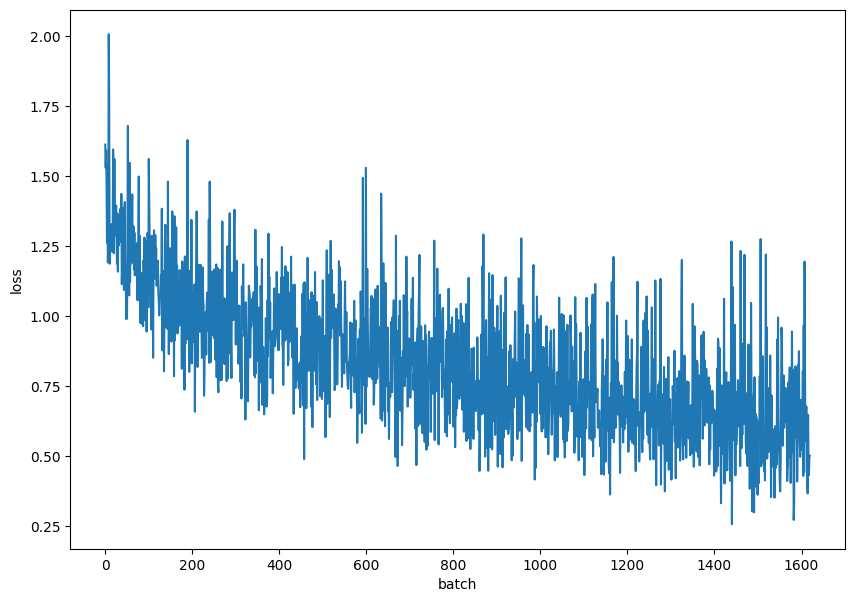

100%|██████████| 108/108 [01:26<00:00,  1.25it/s]


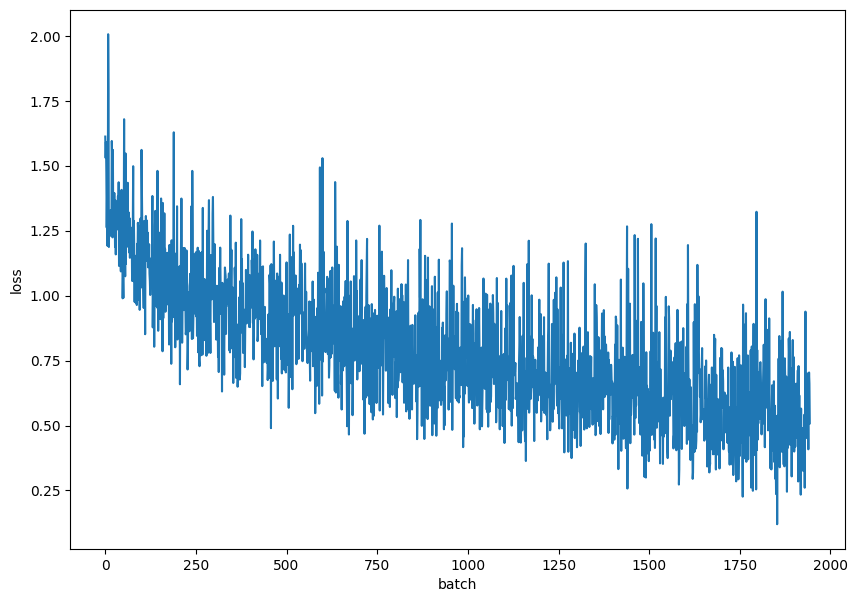

100%|██████████| 108/108 [01:26<00:00,  1.25it/s]


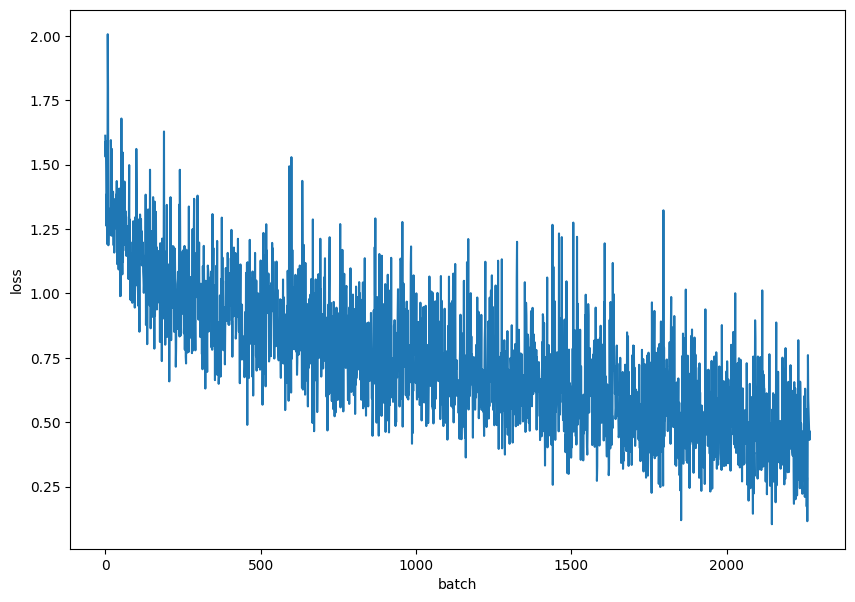

100%|██████████| 108/108 [01:25<00:00,  1.26it/s]


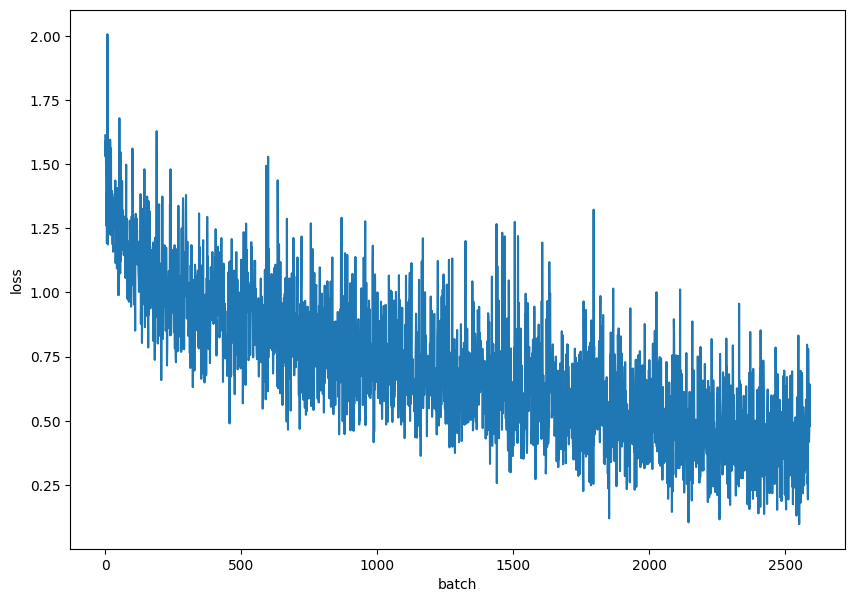

100%|██████████| 108/108 [01:25<00:00,  1.26it/s]


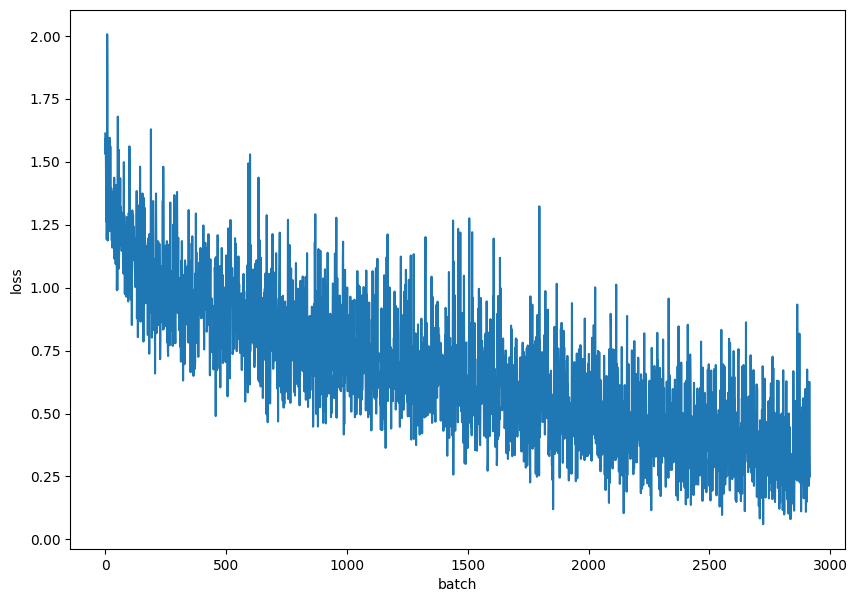

100%|██████████| 108/108 [01:25<00:00,  1.26it/s]


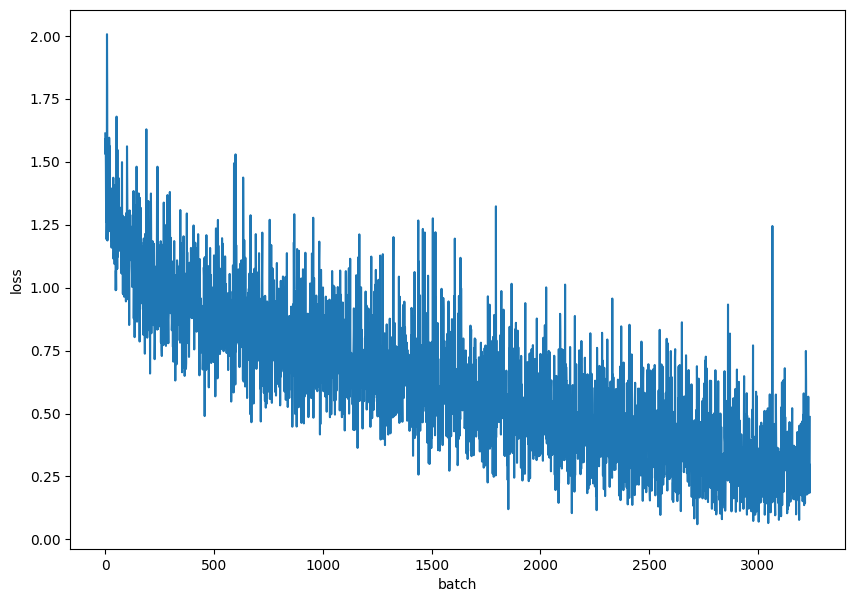

100%|██████████| 108/108 [01:25<00:00,  1.26it/s]


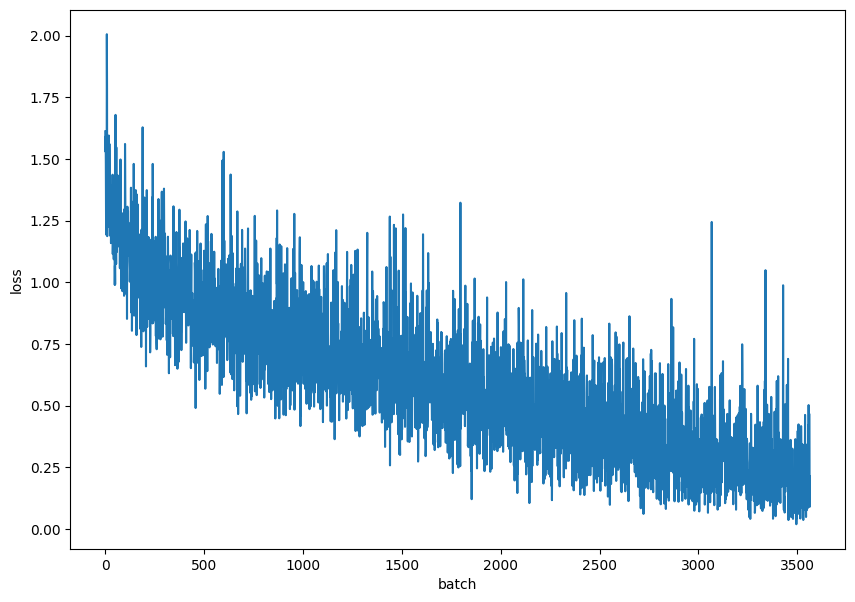

100%|██████████| 108/108 [01:25<00:00,  1.26it/s]


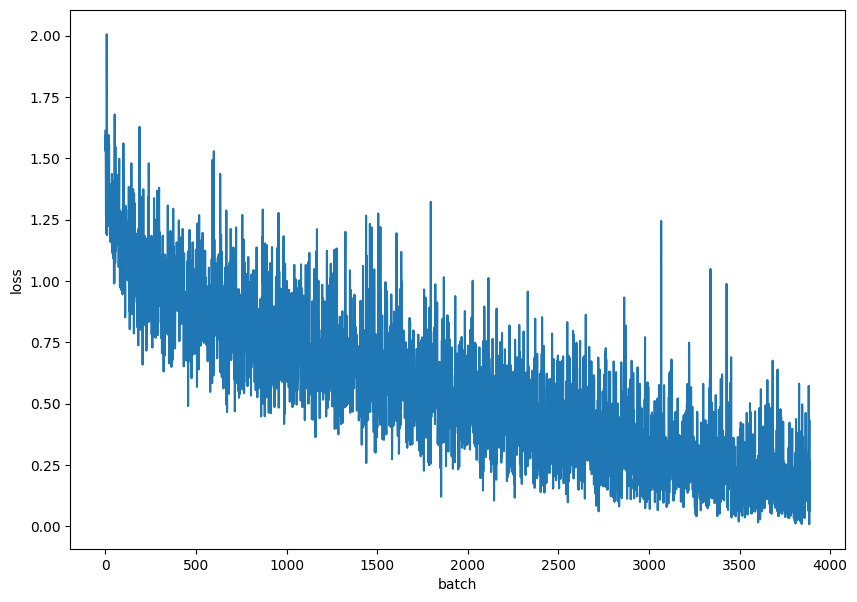

100%|██████████| 108/108 [01:25<00:00,  1.26it/s]


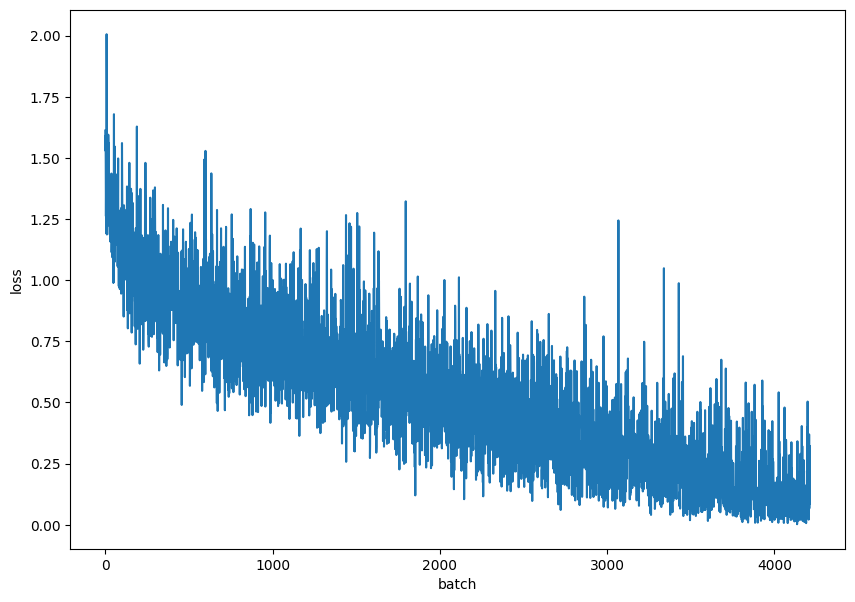

100%|██████████| 108/108 [01:25<00:00,  1.26it/s]


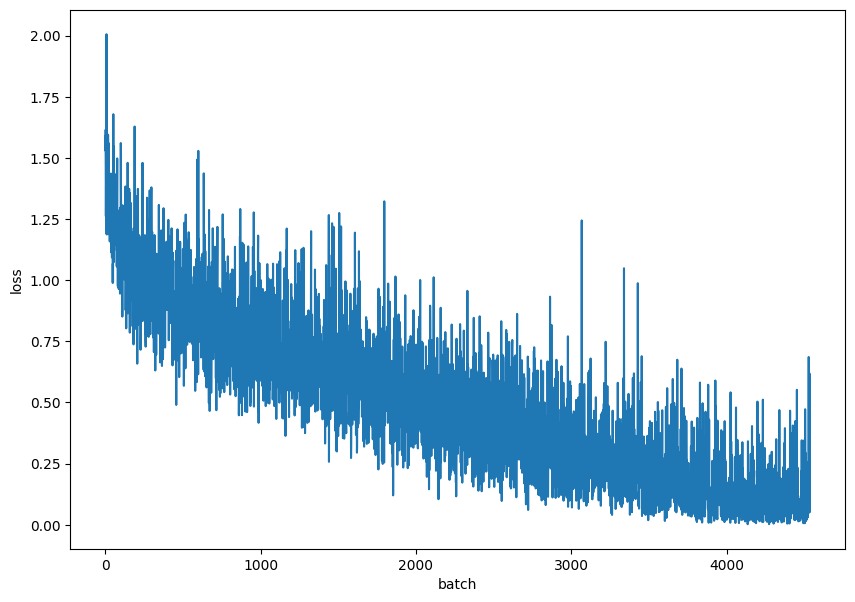

100%|██████████| 108/108 [01:25<00:00,  1.26it/s]


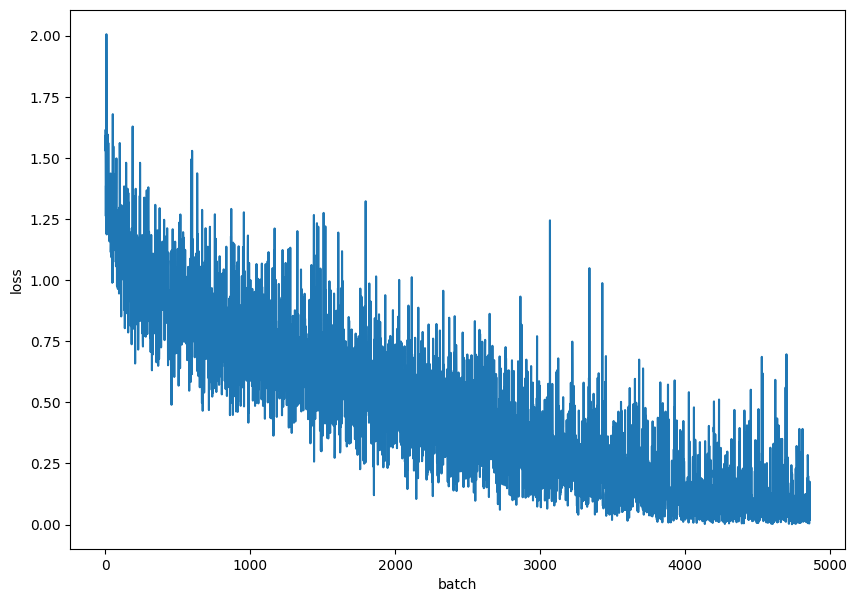

100%|██████████| 108/108 [01:25<00:00,  1.26it/s]


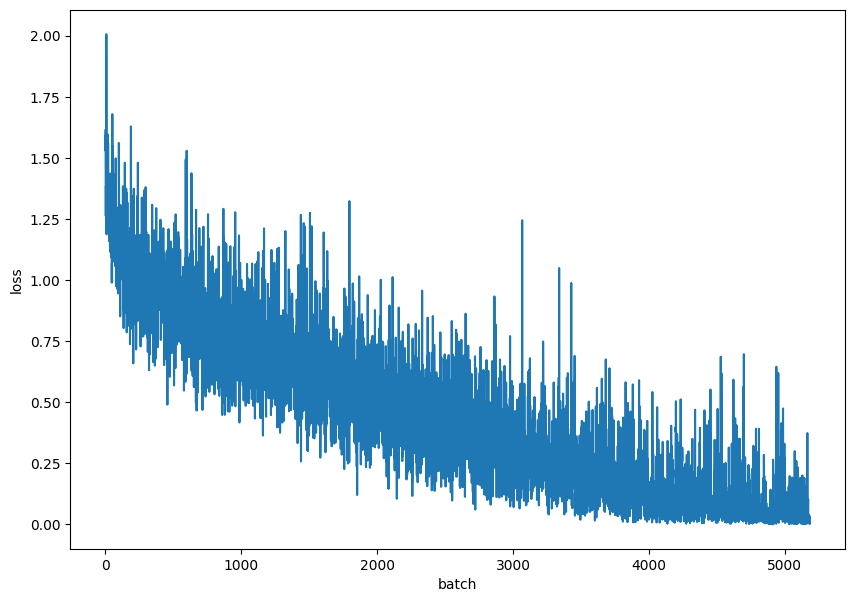

100%|██████████| 108/108 [01:25<00:00,  1.26it/s]


In [ ]:
losses, accuracy = train_with_eval(model, optimizer, criterion, num_epoch, train_loader, test_loader, 3)

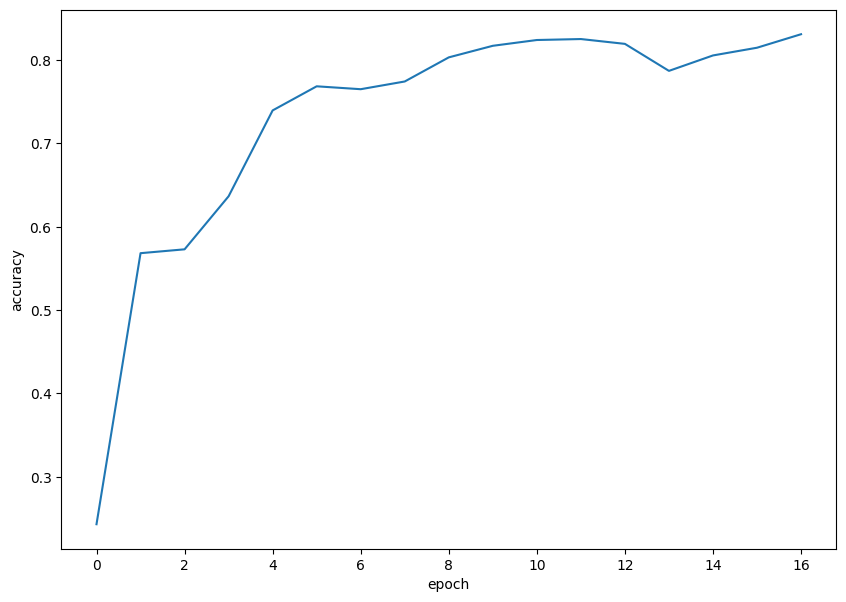

In [ ]:
plot_accuracy(accuracy)

In [ ]:
acc, mistakes = evaluate_classes(model, test_loader)

<ipython-input-18-a82973b3347d>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logs = torch.tensor(logits.argmax(dim=1))


In [ ]:
for x in acc:
  print(x)

0.8431372549019608
0.8333333333333334
0.821656050955414
0.891156462585034
0.7817258883248731


In [ ]:
evaluate(model, test_loader)

100%|██████████| 27/27 [00:06<00:00,  4.12it/s]


0.8310185074806213

## try 12:

In [ ]:
model_2 = Net_2()

optimizer = torch.optim.Adam(model_2.parameters(), 0.0005)
criterion = nn.CrossEntropyLoss()
num_epoch = 10

In [ ]:
losses, acc, val_losses = train_with_val_loss(model_2, optimizer, criterion, num_epoch, train_loader, test_loader, 2)

100%|██████████| 108/108 [01:26<00:00,  1.25it/s]


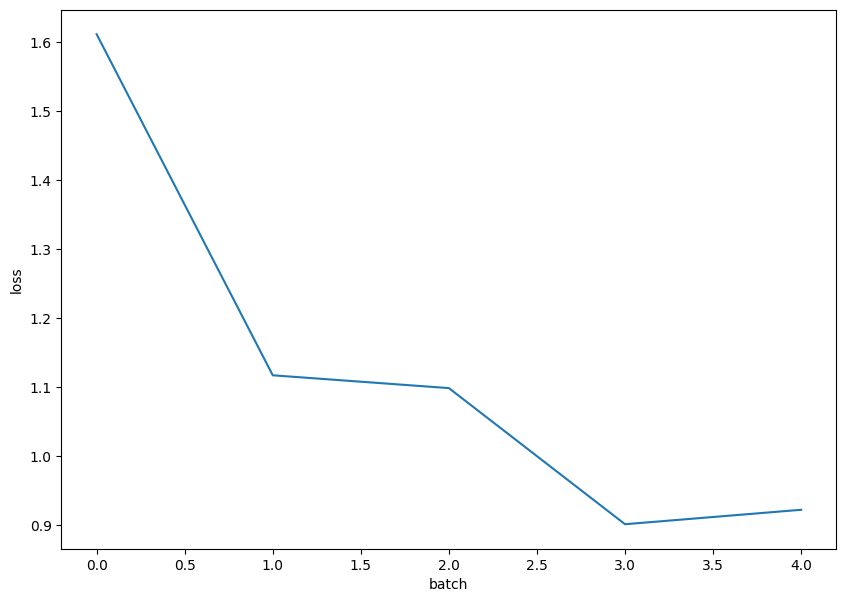

In [ ]:
plot_loss([sum(x)/len(x) for x in val_losses])

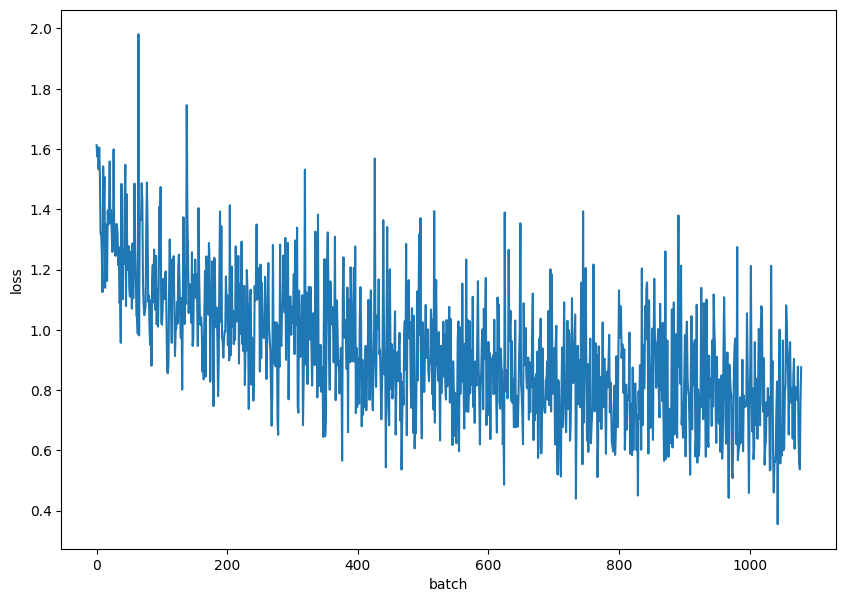

In [ ]:
plot_loss(losses)

In [ ]:
evaluate(model_2, test_loader)

100%|██████████| 27/27 [00:06<00:00,  4.20it/s]


0.7025462985038757

## try 11: lr = 0.0005, wd = 0.0001

In [ ]:
model = Net_2()

optimizer = torch.optim.Adam(model.parameters(), 0.0005, weight_decay = 0.0001)
criterion = nn.CrossEntropyLoss()
num_epoch = 30
epoch_step = 3

In [ ]:
get_loss(model, test_loader, criterion)

100%|██████████| 27/27 [00:06<00:00,  4.11it/s]


1.6097461117638483

In [ ]:
losses, acc, val_losses = train_with_val_loss(model, optimizer, criterion, num_epoch, train_loader, test_loader, epoch_step)

 11%|█         | 12/108 [00:09<01:16,  1.25it/s]

In [ ]:
val_losses

[1.6097461117638483,
 1.613264759381612,
 1.6130752740082916,
 1.6133938409664013,
 1.6134987495563649,
 1.6131337969391435,
 1.6132273762314409,
 1.6133324570126004,
 1.6133106063913416,
 1.6133149067560832]

In [ ]:
losses

[1.613767903160166,
 1.6136552503815405,
 1.6135340045999598,
 1.6134926853356537,
 1.6135562393400404,
 1.613531012226034,
 1.6134982981063701,
 1.6135325509089011,
 1.6135576179733984,
 1.613524388383936,
 1.6135339350612075,
 1.6136247857853219,
 1.6136156662746712,
 1.6135782102743785,
 1.6135999781114083,
 1.613586233721839,
 1.6135072078969743,
 1.613587263557646,
 1.6136531984364544,
 1.613613415647436,
 1.613653067085478,
 1.6136020521322887,
 1.613675598744993,
 1.6135665200374745,
 1.6135835272294503,
 1.6135893872490636,
 1.6135610474480524,
 1.6135507314293474,
 1.6135814642464672,
 1.6135395489357136]

In [ ]:
evaluate(model, test_loader)

100%|██████████| 27/27 [00:06<00:00,  4.07it/s]


0.2222222238779068

## lr = 0.0005

In [ ]:
model = Net_2()

optimizer = torch.optim.Adam(model.parameters(), 0.0005)
criterion = nn.CrossEntropyLoss()
num_epoch = 30
epoch_step = 3

In [ ]:
losses, acc, val_losses = train_with_val_loss(model, optimizer, criterion, num_epoch, train_loader, test_loader, epoch_step)

 69%|██████▉   | 75/108 [01:01<00:26,  1.22it/s]


KeyboardInterrupt: ignored

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


class Transforms:
    def __init__(self, transforms: A.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img, dtype=np.uint8))['image'].to(torch.float32)/255


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        label = self.dataset[idx][1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
dset = ImageFolder(root)
train_dataset, test_dataset = train_test_split(dset, test_size=0.2, stratify = dset.targets)


In [ ]:
train_transform = A.Compose([
        A.Resize(width=224, height=224),
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.GaussNoise(),
            A.PixelDropout()
        ], p = 1),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=1),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
        ], p=1),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.Sharpen(),
            A.Emboss(),
            A.RandomBrightnessContrast(),
        ], p=1),
        A.HueSaturationValue(p=0.3),
        ToTensorV2()
        ])
aug_train_dataset = CustomImageDataset(train_dataset, Transforms(train_transform))

In [ ]:
test_transform = A.Compose([
    A.Resize(width=224, height=224),
    ToTensorV2()
])
train_dataset_ = CustomImageDataset(train_dataset, transform=Transforms(test_transform))
Train_and_aug_train_dataset = torch.utils.data.ConcatDataset([aug_train_dataset,train_dataset_])

In [ ]:
test_transform = A.Compose([
    A.Resize(width=224, height=224),
    ToTensorV2()
])
test_dataset__ = CustomImageDataset(test_dataset, Transforms(test_transform))

In [ ]:
len(Train_and_aug_train_dataset), len(test_dataset)

(6906, 864)

In [ ]:
train_batch = 32
test_batch = 32

train_loader = DataLoader(Train_and_aug_train_dataset, batch_size = train_batch, shuffle = True, num_workers = 2)
test_loader = DataLoader(test_dataset__, batch_size = test_batch, shuffle = False, num_workers=2)

In [ ]:
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 86.0MB/s]


In [ ]:
losses, acc, val_losses =  train_with_val_loss(model_ft, optimizer_ft, criterion, 25, train_loader, test_loader, 3)

100%|██████████| 216/216 [00:42<00:00,  5.06it/s]


In [ ]:
evaluate(model_ft, test_loader)

100%|██████████| 27/27 [00:01<00:00, 18.56it/s]


0.9351851940155029

In [ ]:
evaluate(model_ft, train_loader)

100%|██████████| 216/216 [00:45<00:00,  4.71it/s]


0.9858094453811646

In [ ]:
acc, mistakes = evaluate_classes(model_ft, test_loader)

<ipython-input-33-a82973b3347d>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logs = torch.tensor(logits.argmax(dim=1))


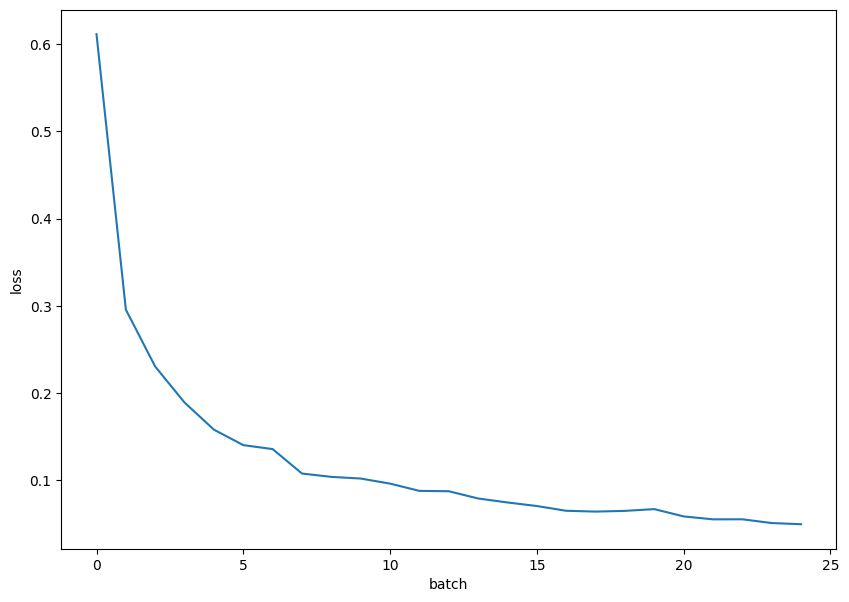

In [ ]:
plot_loss(losses)

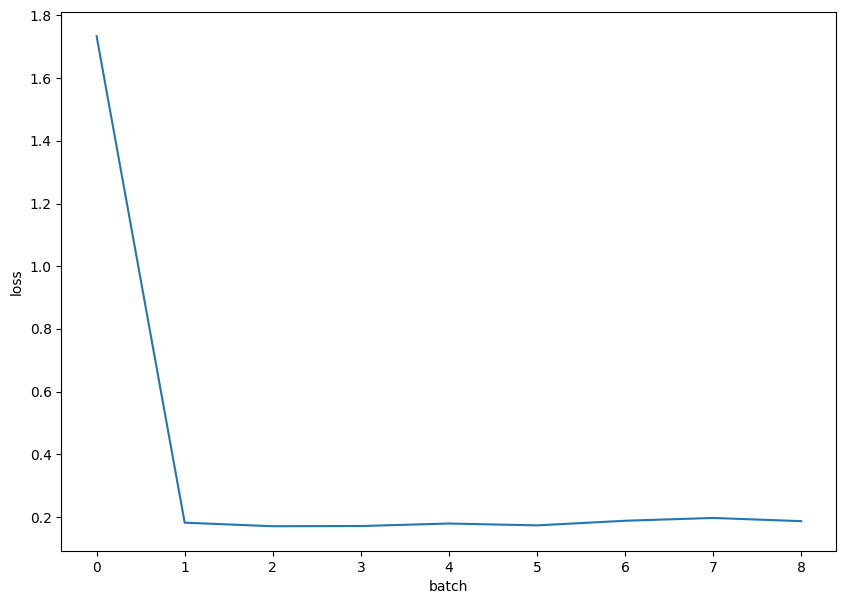

In [ ]:
plot_loss(val_losses)

In [ ]:
acc

[0.9084967320261438,
 0.9714285714285714,
 0.9235668789808917,
 0.9455782312925171,
 0.9187817258883249]

In [ ]:
sum(p.numel() for p in model_ft.parameters())

11179077